## Library import

In [2]:
import pandas as pd
import dask.dataframe as dd

import datetime as dt
import numpy as np
import geopandas as gpd
import scipy
import shapely
import matplotlib.pyplot as plt
import seaborn as sns

from kmodes.kmodes import KModes

In [3]:
pd.set_option('display.max_columns', 35)
pd.set_option('display.max_rows', 110)

## Data import & initial EDA

### Read in data as Pandas df

In [4]:
# Read in processed csv file as Pandas df--data not stored in GitHub repository due to large file size
df_concat = pd.read_csv('~/Documents/GA_2019/Projects/EMS_dispatch_evenings.csv', 
                        parse_dates = ['INCIDENT_DATETIME',
                                      'FIRST_ASSIGNMENT_DATETIME',
                                      'FIRST_ACTIVATION_DATETIME',
                                      'FIRST_ON_SCENE_DATETIME',
                                      'FIRST_TO_HOSP_DATETIME',
                                      'FIRST_HOSP_ARRIVAL_DATETIME',
                                      'INCIDENT_CLOSE_DATETIME'])

**Note:** When the full dataset is being processed, all date-time columns are converted from object type to datetime type. But once the resulting dataframe is saved to .csv, this formatting is lost, because spreadsheet-format doesn't preserve data types. Therefore the 'parse_dates' in the above pd.read_csv is required, it reminds the dates of the format they're supposed to be in. The initial function from Notebook 1 was still necessary as a first step because it formatted the dates so that parse_dates could do its thing without issue.

In [6]:
# How does our data look?
df_concat.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE
0,183654386,2018-12-31 23:59:46,CARDBR,2,CARDBR,2,2018-12-31 23:59:54,Y,8,2019-01-01 00:00:51,2019-01-01 00:07:27,Y,461.0,453.0,2019-01-01 00:15:08,2019-01-01 00:21:51,2019-01-01 01:00:20,N,82.0,BROOKLYN,K6,11201.0
1,183654385,2018-12-31 23:59:20,MVAINJ,4,MVAINJ,4,2019-01-01 00:01:10,Y,110,2019-01-01 00:02:25,2019-01-01 00:07:19,Y,479.0,369.0,NaT,NaT,2019-01-01 00:19:49,N,91.0,QUEENS,Q3,11416.0
2,183654384,2018-12-31 23:58:45,SICK,6,SICK,6,2019-01-01 00:00:43,Y,118,2019-01-01 00:02:08,2019-01-01 00:14:18,Y,933.0,815.0,2019-01-01 00:23:59,2019-01-01 00:34:07,2019-01-01 01:21:30,N,82.0,QUEENS,Q6,11369.0
3,183654383,2018-12-31 23:58:14,INJMAJ,3,INJMAJ,3,2018-12-31 23:58:22,Y,8,2018-12-31 23:58:37,2019-01-01 00:04:10,Y,356.0,348.0,2019-01-01 01:06:29,2019-01-01 01:15:30,2019-01-01 02:02:12,N,82.0,BROOKLYN,K1,11214.0
4,183654382,2018-12-31 23:57:42,UNC,2,UNC,2,2019-01-01 00:00:39,Y,177,2019-01-01 00:01:03,2019-01-01 00:15:00,Y,1038.0,861.0,2019-01-01 01:18:22,2019-01-01 01:22:01,2019-01-01 02:34:19,N,82.0,MANHATTAN,M3,10019.0


In [7]:
# Check dtypes
df_concat.dtypes

CAD_INCIDENT_ID                            int64
INCIDENT_DATETIME                 datetime64[ns]
INITIAL_CALL_TYPE                         object
INITIAL_SEVERITY_LEVEL_CODE                int64
FINAL_CALL_TYPE                           object
FINAL_SEVERITY_LEVEL_CODE                  int64
FIRST_ASSIGNMENT_DATETIME         datetime64[ns]
VALID_DISPATCH_RSPNS_TIME_INDC            object
DISPATCH_RESPONSE_SECONDS_QY               int64
FIRST_ACTIVATION_DATETIME         datetime64[ns]
FIRST_ON_SCENE_DATETIME           datetime64[ns]
VALID_INCIDENT_RSPNS_TIME_INDC            object
INCIDENT_RESPONSE_SECONDS_QY             float64
INCIDENT_TRAVEL_TM_SECONDS_QY            float64
FIRST_TO_HOSP_DATETIME            datetime64[ns]
FIRST_HOSP_ARRIVAL_DATETIME       datetime64[ns]
INCIDENT_CLOSE_DATETIME           datetime64[ns]
HELD_INDICATOR                            object
INCIDENT_DISPOSITION_CODE                float64
BOROUGH                                   object
INCIDENT_DISPATCH_AR

In [8]:
# Convert INCIDENT_DISPOSITION_CODE and ZIPCODE to int type to reduce the amount of memory they use
df_concat[['INCIDENT_DISPOSITION_CODE','ZIPCODE']] = df_concat[['INCIDENT_DISPOSITION_CODE','ZIPCODE']].astype('int64')

In [9]:
# Check datatypes again--now everything is as it should be
df_concat.dtypes

CAD_INCIDENT_ID                            int64
INCIDENT_DATETIME                 datetime64[ns]
INITIAL_CALL_TYPE                         object
INITIAL_SEVERITY_LEVEL_CODE                int64
FINAL_CALL_TYPE                           object
FINAL_SEVERITY_LEVEL_CODE                  int64
FIRST_ASSIGNMENT_DATETIME         datetime64[ns]
VALID_DISPATCH_RSPNS_TIME_INDC            object
DISPATCH_RESPONSE_SECONDS_QY               int64
FIRST_ACTIVATION_DATETIME         datetime64[ns]
FIRST_ON_SCENE_DATETIME           datetime64[ns]
VALID_INCIDENT_RSPNS_TIME_INDC            object
INCIDENT_RESPONSE_SECONDS_QY             float64
INCIDENT_TRAVEL_TM_SECONDS_QY            float64
FIRST_TO_HOSP_DATETIME            datetime64[ns]
FIRST_HOSP_ARRIVAL_DATETIME       datetime64[ns]
INCIDENT_CLOSE_DATETIME           datetime64[ns]
HELD_INDICATOR                            object
INCIDENT_DISPOSITION_CODE                  int64
BOROUGH                                   object
INCIDENT_DISPATCH_AR

In [10]:
df_concat.tail()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE
1936884,130014507,2013-01-01 19:00:46,SICK,6,SICK,6,2013-01-01 19:02:44,Y,118,2013-01-01 19:03:18,2013-01-01 19:11:43,Y,657.0,539.0,2013-01-01 19:52:25,2013-01-01 19:57:01,2013-01-01 20:27:33,N,82,QUEENS,Q2,11435
1936885,130014506,2013-01-01 19:00:40,ASTHMB,2,ASTHMB,2,2013-01-01 19:00:50,Y,10,2013-01-01 19:01:02,2013-01-01 19:04:06,Y,206.0,196.0,NaT,NaT,2013-01-01 20:08:45,N,93,BROOKLYN,K4,11234
1936886,130014505,2013-01-01 19:00:27,TRAUMA,2,TRAUMA,2,2013-01-01 19:00:41,Y,14,2013-01-01 19:00:49,2013-01-01 19:04:49,Y,262.0,248.0,NaT,NaT,2013-01-01 19:27:18,N,87,BRONX,B3,10461
1936887,130014504,2013-01-01 19:00:12,INBLED,3,INBLED,3,2013-01-01 19:00:28,Y,16,2013-01-01 19:00:35,2013-01-01 19:05:28,Y,316.0,300.0,2013-01-01 19:26:21,2013-01-01 19:34:07,2013-01-01 20:02:18,N,82,BRONX,B4,10469
1936888,130014503,2013-01-01 19:00:05,DIFFBR,2,DIFFBR,2,2013-01-01 19:00:23,Y,18,2013-01-01 19:00:31,2013-01-01 19:03:19,Y,194.0,176.0,2013-01-01 19:31:19,2013-01-01 19:33:11,2013-01-01 20:08:28,N,82,BROOKLYN,K6,11205


In [11]:
# Show INCIDENT_DISPOSITION_CODE distribution
df_concat['INCIDENT_DISPOSITION_CODE'].value_counts(normalize = True)

82    0.700417
93    0.116874
90    0.097979
96    0.035845
87    0.032591
91    0.009986
83    0.005264
94    0.000936
95    0.000104
92    0.000005
Name: INCIDENT_DISPOSITION_CODE, dtype: float64

**Note:** Incident disposition codes--
* 82: Transporting patient
* 83: Patient pronounced dead
* 87: Call canceled
* 90: Call unfounded/no patient found
* 91: Condition corrected
* 92: Treated not transported
* 93: Refused medical attention
* 94: Treated & transferred care
* 95: Triaged at scene no transport
* 96: Patient gone upon arrival at scene

In [12]:
df_concat['INITIAL_CALL_TYPE'].value_counts(normalize = True)

SICK      1.460528e-01
INJURY    1.337056e-01
DRUG      9.033404e-02
EDP       8.300269e-02
DIFFBR    8.242031e-02
UNKNOW    6.006746e-02
UNC       5.818764e-02
ABDPN     4.009574e-02
CARD      3.366016e-02
MVAINJ    2.297654e-02
INJMAJ    1.974713e-02
PEDSTR    1.759884e-02
STATEP    1.586720e-02
RESPIR    1.529824e-02
CARDBR    1.379016e-02
ALTMEN    1.353046e-02
ASTHMB    1.344424e-02
OTHER     1.295428e-02
ARREST    1.205335e-02
INJMIN    1.019883e-02
SICPED    9.968047e-03
SEIZR     9.528682e-03
CVAC      8.080484e-03
INBLED    7.910624e-03
ANAPH     6.832090e-03
STAB      5.622935e-03
OBLAB     5.559431e-03
SICMIN    4.541303e-03
OBMAJ     4.535108e-03
SHOT      3.312012e-03
TRAUMA    3.187070e-03
CVA       2.898979e-03
PD13      2.418311e-03
STNDBY    2.310922e-03
HYPTN     2.308341e-03
GYNHEM    2.219022e-03
MEDRXN    2.213343e-03
OBMIS     2.142611e-03
CHOKE     1.967588e-03
OBCOMP    1.756425e-03
INHALE    1.683628e-03
COLD      1.467818e-03
SICKFC    1.447166e-03
MCI21P    1

In [14]:
df_concat.groupby('INITIAL_CALL_TYPE').count()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE
INITIAL_CALL_TYPE,,,,,,,,,,,,,,,,,,,,,
ABDPFC,114,114,114,114,114,114,114,114,114,113,114,113,113,108,108,114,114,114,114,114,114
ABDPN,77661,77661,77661,77661,77661,77661,77661,77661,77584,76462,77661,76462,76462,70298,69873,77651,77661,77661,77661,77661,77661
ACC,8,8,8,8,8,8,8,8,8,6,8,6,6,2,2,8,8,8,8,8,8
ACTIVE,27,27,27,27,27,27,27,27,27,23,27,23,23,3,3,27,27,27,27,27,27
ALTMEN,26207,26207,26207,26207,26207,26207,26207,26207,26190,25793,26207,25793,25793,20123,19999,26205,26207,26207,26207,26207,26207
ALTMFC,14,14,14,14,14,14,14,14,14,14,14,14,14,13,13,14,14,14,14,14,14
AMPMAJ,42,42,42,42,42,42,42,42,42,41,42,41,41,26,26,42,42,42,42,42,42
AMPMIN,355,355,355,355,355,355,355,355,353,345,355,345,345,301,301,355,355,355,355,355,355
ANAPFC,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1


**Note:** The incident disposition codes of interest to us are 87 & 94: 87 refers to calls canceled, generally by other units, while 94 refers to calls where the unit provided some treatment on-scene, but the patient was transported by another unit. 

In [19]:
# 63102 total 87s in our dataset
# 64937 total 87+94s in our dataset
df_concat[(df_concat['INCIDENT_DISPOSITION_CODE'] == 87) ^ (df_concat['INCIDENT_DISPOSITION_CODE'] == 94)]['FIRST_ON_SCENE_DATETIME']

203       2018-12-31 23:07:42
262                       NaT
274       2018-12-31 22:42:57
317                       NaT
343                       NaT
                  ...        
1936791   2013-01-01 19:44:15
1936867                   NaT
1936873                   NaT
1936877   2013-01-01 19:11:16
1936886   2013-01-01 19:04:49
Name: FIRST_ON_SCENE_DATETIME, Length: 64937, dtype: datetime64[ns]

In [17]:
# How many calls where a unit was actually dispatched and canceled on-scene rather than ahead of time?
df_concat[(df_concat['INCIDENT_DISPOSITION_CODE'] == 87) ^ (df_concat['INCIDENT_DISPOSITION_CODE'] == 94)]['FIRST_ON_SCENE_DATETIME'].notnull().sum()

43520

In [18]:
df_concat[(df_concat['INCIDENT_DISPOSITION_CODE'] == 87) ^ (df_concat['INCIDENT_DISPOSITION_CODE'] == 94)]['FIRST_ON_SCENE_DATETIME'].notnull()

203         True
262        False
274         True
317        False
343        False
           ...  
1936791     True
1936867    False
1936873    False
1936877     True
1936886     True
Name: FIRST_ON_SCENE_DATETIME, Length: 64937, dtype: bool

In [19]:
df_canceled = df_concat[(df_concat['INCIDENT_DISPOSITION_CODE'] == 87) ^ (df_concat['INCIDENT_DISPOSITION_CODE'] == 94)]

In [20]:
df_canceled[df_canceled['FIRST_ON_SCENE_DATETIME'].isnull()]

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE
262,183654085,2018-12-31 22:41:01,UNKNOW,4,UNKNOW,4,2018-12-31 22:42:25,Y,84,2018-12-31 22:43:07,NaT,N,NaN,NaN,NaT,NaT,2018-12-31 22:46:33,N,87,MANHATTAN,M3,10022
317,183654022,2018-12-31 22:25:55,UNKNOW,4,UNKNOW,4,2018-12-31 22:26:10,Y,15,2018-12-31 22:26:22,NaT,N,NaN,NaN,NaT,NaT,2018-12-31 22:31:45,N,87,BROOKLYN,K5,11216
343,183653988,2018-12-31 22:17:05,DRUG,4,DRUG,4,2018-12-31 22:17:21,Y,16,2018-12-31 22:17:30,NaT,N,NaN,NaN,NaT,NaT,2018-12-31 22:18:10,N,87,BROOKLYN,K7,11211
385,183653934,2018-12-31 22:05:30,INJURY,5,INJURY,5,2018-12-31 22:10:54,Y,324,NaT,NaT,N,NaN,NaN,NaT,NaT,2018-12-31 22:16:37,N,87,MANHATTAN,M3,10036
389,183653929,2018-12-31 22:04:44,DRUG,4,DRUG,4,2018-12-31 22:04:59,Y,15,2018-12-31 22:05:45,NaT,N,NaN,NaN,NaT,NaT,2018-12-31 22:10:11,N,87,BROOKLYN,K6,11217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936529,130014905,2013-01-01 21:05:38,EDP,7,EDP,7,2013-01-01 21:07:58,Y,140,2013-01-01 21:08:08,NaT,N,NaN,NaN,NaT,NaT,2013-01-01 21:24:05,N,87,BROOKLYN,K3,11226
1936588,130014841,2013-01-01 20:43:01,STAB,3,STAB,3,2013-01-01 20:43:39,Y,38,2013-01-01 20:43:49,NaT,N,NaN,NaN,NaT,NaT,2013-01-01 20:44:42,N,87,MANHATTAN,M3,10036
1936689,130014719,2013-01-01 20:04:48,DIFFBR,2,DIFFBR,2,2013-01-01 20:05:08,Y,20,2013-01-01 20:05:20,NaT,N,NaN,NaN,NaT,NaT,2013-01-01 20:06:56,N,87,QUEENS,Q3,11421
1936867,130014525,2013-01-01 19:05:24,DRUG,4,DRUG,4,2013-01-01 19:05:38,Y,14,2013-01-01 19:06:56,NaT,N,NaN,NaN,NaT,NaT,2013-01-01 19:11:21,N,87,MANHATTAN,M7,10035


In [200]:
#df_canceled.shape

(64937, 23)

## Call length

In [24]:
#length_onscene = df_87['INCIDENT_CLOSE_DATETIME'] - df_87['FIRST_ON_SCENE_DATETIME']

In [21]:
# Isolating out all of the NOT null values for on-scene arrival, etc
df_canceled = df_canceled[df_canceled['FIRST_ON_SCENE_DATETIME'].notnull()]

In [22]:
df_canceled['CALL_LENGTH'] = (df_canceled['INCIDENT_CLOSE_DATETIME'] - df_canceled['FIRST_ON_SCENE_DATETIME']).astype('timedelta64[s]')

In [23]:
df_canceled.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH
203,183654152,2018-12-31 22:57:02,RESPIR,4,RESPIR,4,2018-12-31 22:58:17,Y,75,2018-12-31 22:58:25,2018-12-31 23:07:42,Y,640.0,565.0,NaT,NaT,2018-12-31 23:32:32,N,87,BROOKLYN,K7,11221,1490.0
274,183654073,2018-12-31 22:38:22,UNC,2,UNC,2,2018-12-31 22:38:35,Y,13,2018-12-31 22:38:49,2018-12-31 22:42:57,Y,275.0,262.0,NaT,NaT,2018-12-31 22:55:58,N,87,BROOKLYN,K4,11236,781.0
352,183653977,2018-12-31 22:14:41,UNKNOW,4,UNKNOW,4,2018-12-31 22:15:18,Y,37,2018-12-31 22:15:30,2018-12-31 22:23:26,Y,525.0,488.0,NaT,NaT,2018-12-31 22:35:52,N,87,BROOKLYN,K1,11210,746.0
412,183653901,2018-12-31 21:59:05,PEDSTR,3,PEDSTR,3,2018-12-31 21:59:13,Y,8,2018-12-31 21:59:25,2018-12-31 22:06:43,Y,458.0,450.0,NaT,NaT,2018-12-31 22:29:08,N,87,BROOKLYN,K4,11236,1345.0
435,183653875,2018-12-31 21:51:13,UNKNOW,4,UNKNOW,4,2018-12-31 21:51:35,Y,22,2018-12-31 21:51:55,2018-12-31 21:53:59,Y,166.0,144.0,NaT,NaT,2018-12-31 21:56:45,N,87,BROOKLYN,K6,11231,166.0


In [24]:
np.max(df_canceled['CALL_LENGTH'])

20879.0

In [25]:
df_canceled[df_canceled['CALL_LENGTH'] > 15000]

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH
61710,182984341,2018-10-25 21:57:54,STNDBY,8,STNDBY,8,2018-10-25 21:58:04,Y,10,2018-10-25 21:58:04,2018-10-25 22:05:09,Y,435.0,425.0,NaT,NaT,2018-10-26 02:33:06,N,87,MANHATTAN,M3,10022,16077.0
66104,182934496,2018-10-20 22:24:28,MCI21,2,MCI21,2,2018-10-20 22:26:43,Y,135,2018-10-20 22:29:33,2018-10-20 22:42:31,Y,1083.0,948.0,NaT,NaT,2018-10-21 03:19:36,N,87,BRONX,B1,10474,16625.0
87153,182723817,2018-09-29 19:59:27,MCI21,2,MCI24,2,2018-09-29 20:00:11,Y,44,2018-09-29 20:00:29,2018-09-29 20:08:43,Y,556.0,512.0,NaT,NaT,2018-09-30 01:05:25,N,87,QUEENS,Q6,11101,17802.0
167890,181914440,2018-07-10 21:45:44,STNDBY,8,STNDBY,8,2018-07-10 21:45:44,Y,0,2018-07-10 21:45:44,2018-07-10 21:45:44,Y,0.0,0.0,NaT,NaT,2018-07-11 02:03:51,N,87,MANHATTAN,M3,10018,15487.0
195874,181653753,2018-06-14 19:04:06,STNDBY,8,STNDBY,8,2018-06-14 19:24:50,Y,1244,2018-06-14 19:25:22,2018-06-14 19:37:44,Y,2018.0,774.0,NaT,NaT,2018-06-15 00:09:19,N,87,QUEENS,Q6,11101,16295.0
443747,172643971,2017-09-21 21:37:26,STNDBY,8,STNDBY,8,2017-09-21 21:37:26,Y,0,2017-09-21 21:37:26,2017-09-21 21:37:26,Y,0.0,0.0,NaT,NaT,2017-09-22 02:30:56,N,87,MANHATTAN,M3,10017,17610.0
532954,171713548,2017-06-20 19:09:04,STNDBY,8,STNDBY,8,2017-06-20 19:09:04,Y,0,2017-06-20 19:09:04,2017-06-20 19:09:04,Y,0.0,0.0,NaT,NaT,2017-06-21 00:05:45,N,87,QUEENS,Q6,11102,17801.0
663143,170283303,2017-01-28 19:22:17,STNDBY,8,STNDBY,8,2017-01-28 19:22:27,Y,10,2017-01-28 19:22:35,2017-01-28 19:24:31,Y,134.0,124.0,NaT,NaT,2017-01-29 01:12:30,N,87,QUEENS,Q2,11430,20879.0
700619,163523347,2016-12-17 19:31:14,MCI21P,2,MCI21P,2,2016-12-17 19:32:49,Y,95,2016-12-17 19:33:02,2016-12-17 19:40:07,Y,533.0,438.0,NaT,NaT,2016-12-17 23:56:54,N,87,QUEENS,Q6,11368,15407.0
702293,163503852,2016-12-15 20:44:34,MCI21P,2,MCI21P,2,2016-12-15 20:44:57,Y,23,2016-12-15 20:45:32,2016-12-15 20:50:00,Y,326.0,303.0,NaT,NaT,2016-12-16 01:01:12,N,87,QUEENS,Q4,11378,15072.0


In [26]:
df_canceled[df_canceled['CALL_LENGTH'] > 6000]['INCIDENT_DISPOSITION_CODE'].value_counts()

87    162
94     21
Name: INCIDENT_DISPOSITION_CODE, dtype: int64

In [240]:
df_canceled[df_canceled['CALL_LENGTH'] > 6000][['CAD_INCIDENT_ID', 'INCIDENT_DATETIME', 'INCIDENT_DISPOSITION_CODE',
                                               'INITIAL_CALL_TYPE', 'INITIAL_SEVERITY_LEVEL_CODE',
                                               'INCIDENT_DISPATCH_AREA', 'ZIPCODE']]

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INCIDENT_DISPOSITION_CODE,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_DISPATCH_AREA,ZIPCODE
4270,183613851,2018-12-27 21:41:36,87,INJURY,5,M8,10039
7371,183574077,2018-12-23 23:27:49,87,MCI21,2,Q6,11368
11820,183533908,2018-12-19 20:43:09,87,STNDBY,8,S1,10304
46706,183143763,2018-11-10 21:42:40,87,MCI21,2,B2,10457
55930,183044604,2018-10-31 23:59:13,87,EDPC,7,K1,11229
...,...,...,...,...,...,...,...
1922013,130193474,2013-01-19 22:33:56,94,DIFFBR,2,Q1,11691
1923593,130173641,2013-01-17 22:28:18,87,PD13,7,K3,11203
1931538,130074156,2013-01-07 22:34:06,87,EDP,7,M2,10035
1932215,130063686,2013-01-06 23:27:45,87,EDP,7,S2,10314


In [238]:
df_canceled.shape

(43520, 23)

In [193]:
df_canceled['INITIAL_SEVERITY_LEVEL_CODE'].value_counts()

4    16263
5    11777
2    10785
7     9982
3     7307
6     7041
8     1007
1      769
9        6
Name: INITIAL_SEVERITY_LEVEL_CODE, dtype: int64

In [195]:
df_canceled[df_canceled['INITIAL_SEVERITY_LEVEL_CODE'] == 8]

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH
1206,183643988,2018-12-30 22:36:42,STNDBY,8,STNDBY,8,2018-12-30 22:38:24,Y,102,2018-12-30 22:39:36,2018-12-30 22:43:51,Y,429.0,327.0,NaT,NaT,2018-12-30 22:48:42,N,87,QUEENS,Q6,11105,247.0
7800,183573603,2018-12-23 21:02:01,STNDBY,8,STNDBY,8,2018-12-23 21:02:17,Y,16,2018-12-23 21:02:33,NaT,N,NaN,NaN,NaT,NaT,2018-12-23 21:03:19,N,87,BROOKLYN,K7,11221,118.0
8202,183564494,2018-12-22 23:49:54,STNDBY,8,STNDBY,8,2018-12-23 00:08:03,Y,1089,2018-12-23 00:08:41,NaT,N,NaN,NaN,NaT,NaT,2018-12-23 00:09:53,Y,87,BRONX,B1,10456,702.0
9038,183563547,2018-12-22 19:39:03,STNDBY,8,STNDBY,8,2018-12-22 19:39:03,Y,0,2018-12-22 19:39:03,2018-12-22 19:39:03,Y,0.0,0.0,NaT,NaT,2018-12-22 20:15:58,N,87,MANHATTAN,M2,10001,567.0
10448,183544602,2018-12-20 22:52:11,STNDBY,8,STNDBY,8,2018-12-20 22:52:21,Y,10,2018-12-20 22:52:47,2018-12-20 22:56:16,Y,245.0,235.0,NaT,NaT,2018-12-20 23:14:41,N,87,BRONX,B3,10475,265.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928755,130113598,2013-01-11 19:45:58,STNDBY,8,STNDBY,8,2013-01-11 19:47:29,Y,91,2013-01-11 19:47:49,2013-01-11 19:58:29,Y,751.0,660.0,NaT,NaT,2013-01-11 20:05:02,N,87,MANHATTAN,M3,10001,NaN
1929544,130103650,2013-01-10 20:01:21,STNDBY,8,STNDBY,8,2013-01-10 20:24:58,Y,1417,2013-01-10 20:25:19,NaT,N,NaN,NaN,NaT,NaT,2013-01-10 20:34:03,Y,87,BRONX,B1,10454,NaN
1929602,130103584,2013-01-10 19:39:12,STNDBY,8,STNDBY,8,2013-01-10 19:39:12,Y,0,2013-01-10 19:39:12,2013-01-10 19:39:12,Y,0.0,0.0,NaT,NaT,2013-01-10 19:45:34,N,87,QUEENS,Q2,11432,NaN
1930652,130084244,2013-01-08 23:04:38,STNDBY,8,STNDBY,8,2013-01-08 23:05:12,Y,34,2013-01-08 23:05:19,2013-01-08 23:07:13,Y,155.0,121.0,NaT,NaT,2013-01-08 23:14:39,N,87,RICHMOND / STATEN ISLAND,S1,10305,NaN


In [236]:
df_canceled[(df_canceled['CALL_LENGTH'] > 300) & (df_canceled['CALL_LENGTH'] > 1000)]

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH
203,183654152,2018-12-31 22:57:02,RESPIR,4,RESPIR,4,2018-12-31 22:58:17,Y,75,2018-12-31 22:58:25,2018-12-31 23:07:42,Y,640.0,565.0,NaT,NaT,2018-12-31 23:32:32,N,87,BROOKLYN,K7,11221,1490.0
412,183653901,2018-12-31 21:59:05,PEDSTR,3,PEDSTR,3,2018-12-31 21:59:13,Y,8,2018-12-31 21:59:25,2018-12-31 22:06:43,Y,458.0,450.0,NaT,NaT,2018-12-31 22:29:08,N,87,BROOKLYN,K4,11236,1345.0
459,183653849,2018-12-31 21:43:53,GYNMAJ,3,GYNMAJ,3,2018-12-31 21:44:23,Y,30,2018-12-31 21:44:39,2018-12-31 21:50:39,Y,406.0,376.0,NaT,NaT,2018-12-31 22:34:25,N,94,QUEENS,Q2,11423,2626.0
525,183653769,2018-12-31 21:20:53,INJMAJ,3,INJMAJ,3,2018-12-31 21:20:59,Y,6,2018-12-31 21:21:11,2018-12-31 21:25:15,Y,262.0,256.0,NaT,NaT,2018-12-31 21:42:17,N,87,MANHATTAN,M4,10023,1022.0
577,183653709,2018-12-31 21:05:35,INHALE,5,ALTMEN,3,2018-12-31 21:06:02,Y,27,2018-12-31 21:06:31,2018-12-31 21:08:33,Y,178.0,151.0,NaT,NaT,2018-12-31 21:49:12,N,94,BROOKLYN,K6,11231,2439.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935843,130023491,2013-01-02 20:45:54,UNC,2,UNC,2,2013-01-02 20:46:48,Y,54,2013-01-02 20:47:13,2013-01-02 20:51:22,Y,328.0,274.0,NaT,NaT,2013-01-02 21:09:03,N,87,BROOKLYN,K6,11225,1061.0
1935950,130023367,2013-01-02 20:01:36,PEDSTR,3,UNC,2,2013-01-02 20:02:09,Y,33,2013-01-02 20:02:23,2013-01-02 20:10:30,Y,534.0,501.0,NaT,NaT,2013-01-02 20:34:14,N,94,BROOKLYN,K4,11234,1424.0
1936411,130015033,2013-01-01 21:50:13,EDP,7,EDP,7,2013-01-01 21:50:36,Y,23,2013-01-01 21:50:48,2013-01-01 22:05:09,Y,896.0,873.0,NaT,NaT,2013-01-01 22:26:29,N,87,QUEENS,Q7,11354,1280.0
1936589,130014839,2013-01-01 20:39:56,RAPE,6,RAPE,4,2013-01-01 20:41:20,Y,84,2013-01-01 20:41:38,2013-01-01 20:45:55,Y,359.0,275.0,NaT,NaT,2013-01-01 21:58:38,N,87,MANHATTAN,M7,10029,4363.0


In [47]:
# Create a column in df_canceled_nl showing log-scale of call length
df_canceled['LOG_LENGTH'] = np.log(df_canceled['CALL_LENGTH'])

**Note:** Standby events removed from the dataset for purposes of the histograms because they aren't incidents where volunteer units would be picking up the calls as well. Also, a respectable number of the longer call lengths are associated with standby events--possibly because a CAD # might be assigned at the start of the event and not canceled 'til after it's over. Additionally, all call lengths over an hour were removed as well, under the assumption that for the most part, they're some form of operator error (bugs in the system), or assisting other units at an emergency scene (think car crash with multiple injured patients) and not officially getting "canceled" until they leave the scene.

In [48]:
df_canceled_ns = df_canceled[df_canceled['INITIAL_CALL_TYPE'] != 'STNDBY']

In [49]:
df_canceled_nl = df_canceled_ns[df_canceled_ns['CALL_LENGTH'] < 3600]

In [50]:
df_canceled_nl.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH,LOG_LENGTH
203,183654152,2018-12-31 22:57:02,RESPIR,4,RESPIR,4,2018-12-31 22:58:17,Y,75,2018-12-31 22:58:25,2018-12-31 23:07:42,Y,640.0,565.0,NaT,NaT,2018-12-31 23:32:32,N,87,BROOKLYN,K7,11221,1490.0,7.306531
274,183654073,2018-12-31 22:38:22,UNC,2,UNC,2,2018-12-31 22:38:35,Y,13,2018-12-31 22:38:49,2018-12-31 22:42:57,Y,275.0,262.0,NaT,NaT,2018-12-31 22:55:58,N,87,BROOKLYN,K4,11236,781.0,6.660575
352,183653977,2018-12-31 22:14:41,UNKNOW,4,UNKNOW,4,2018-12-31 22:15:18,Y,37,2018-12-31 22:15:30,2018-12-31 22:23:26,Y,525.0,488.0,NaT,NaT,2018-12-31 22:35:52,N,87,BROOKLYN,K1,11210,746.0,6.614726
412,183653901,2018-12-31 21:59:05,PEDSTR,3,PEDSTR,3,2018-12-31 21:59:13,Y,8,2018-12-31 21:59:25,2018-12-31 22:06:43,Y,458.0,450.0,NaT,NaT,2018-12-31 22:29:08,N,87,BROOKLYN,K4,11236,1345.0,7.204149
435,183653875,2018-12-31 21:51:13,UNKNOW,4,UNKNOW,4,2018-12-31 21:51:35,Y,22,2018-12-31 21:51:55,2018-12-31 21:53:59,Y,166.0,144.0,NaT,NaT,2018-12-31 21:56:45,N,87,BROOKLYN,K6,11231,166.0,5.111988


In [44]:
df_canceled_nl['LOG_LENGTH'].max()

8.187855443695623

In [37]:
df_canceled_nl['LOG_LENGTH'].value_counts()

5.652489    73
5.529429    70
5.976351    70
5.347108    68
5.327876    68
            ..
7.739794     1
8.021256     1
7.513709     1
7.522941     1
7.848934     1
Name: LOG_LENGTH, Length: 2910, dtype: int64

In [41]:
df_canceled_nl[df_canceled_nl['CALL_LENGTH'] == 0]

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH,LOG_LENGTH
670868,170193807,2017-01-19 20:33:29,INJURY,5,INJURY,5,2017-01-19 20:33:53,Y,24,2017-01-19 20:34:03,2017-01-19 20:38:14,Y,285.0,261.0,NaT,NaT,2017-01-19 20:38:14,N,87,MANHATTAN,M2,10001,0.0,-inf
749721,162953756,2016-10-21 20:03:58,INJURY,5,INJURY,5,2016-10-21 20:04:18,Y,20,2016-10-21 20:04:27,2016-10-21 20:15:02,Y,664.0,644.0,NaT,NaT,2016-10-21 20:15:02,N,87,QUEENS,Q6,11368,0.0,-inf
1496740,141803128,2014-06-29 19:20:46,UNC,2,UNC,2,2014-06-29 19:21:10,Y,24,2014-06-29 19:21:18,2014-06-29 19:25:44,Y,298.0,274.0,NaT,NaT,2014-06-29 19:25:44,N,87,MANHATTAN,M4,10025,0.0,-inf


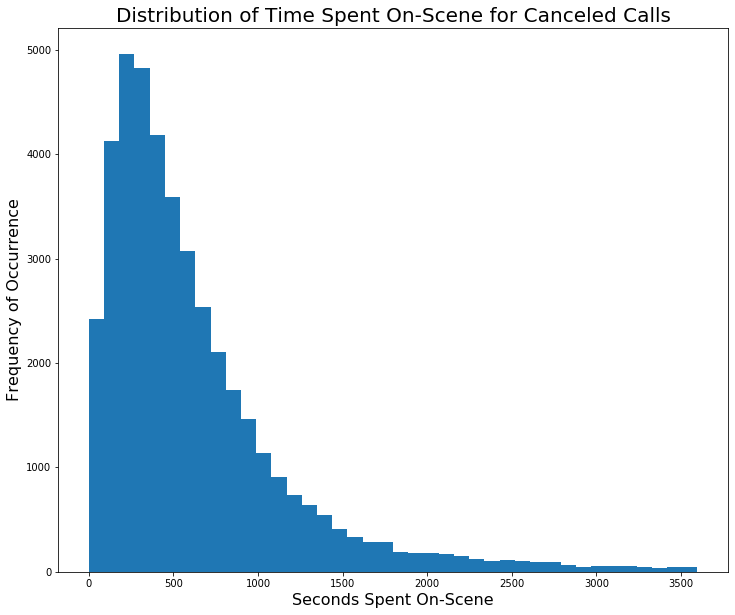

In [352]:
# Distribution of time spent on-scene for canceled calls
df_canceled_nl['CALL_LENGTH'].plot.hist(bins = 40, figsize = (12, 10));
plt.title('Distribution of Time Spent On-Scene for Canceled Calls', fontsize = 20);
plt.xlabel('Seconds Spent On-Scene', fontsize = 16);
plt.ylabel('Frequency of Occurrence', fontsize = 16);
#plt.xscale('log');

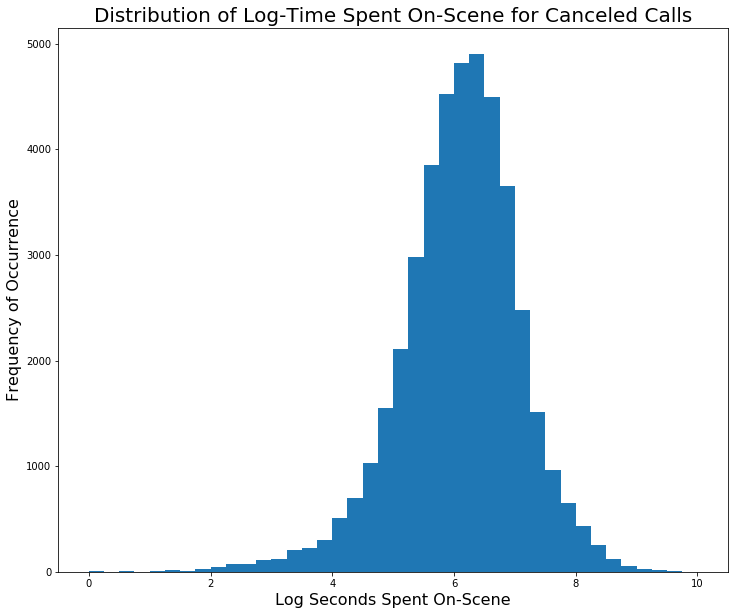

In [53]:
# Distribution of log-time spent on-scene for canceled calls
df_canceled_ns['LOG_LENGTH'].plot.hist(bins = 40, figsize = (12, 10), range = [0,10]);
plt.title('Distribution of Log-Time Spent On-Scene for Canceled Calls', fontsize = 20);
plt.xlabel('Log Seconds Spent On-Scene', fontsize = 16);
plt.ylabel('Frequency of Occurrence', fontsize = 16);

In [75]:
df_87[df_87['INITIAL_SEVERITY_LEVEL_CODE'] != df_87['FINAL_SEVERITY_LEVEL_CODE']]

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE
1844,183643278,2018-12-30 19:00:48,EDPC,5,ALTMEN,3,2018-12-30 19:01:18,Y,30,2018-12-30 19:01:42,2018-12-30 19:05:52,Y,304.0,274.0,NaT,NaT,2018-12-30 19:09:12,N,87.0,MANHATTAN,M2,10009.0
2058,183634168,2018-12-29 22:45:46,EDP,7,EDPC,5,2018-12-29 22:45:52,Y,6,2018-12-29 22:46:11,2018-12-29 22:58:09,Y,743.0,737.0,NaT,NaT,2018-12-29 23:02:42,N,87.0,BROOKLYN,K3,11226.0
2541,183633599,2018-12-29 20:20:10,UNC,2,SEIZR,3,2018-12-29 20:20:37,Y,27,2018-12-29 20:21:08,2018-12-29 20:28:44,Y,514.0,487.0,NaT,NaT,2018-12-29 20:35:29,N,87.0,BROOKLYN,K4,11234.0
2809,183624738,2018-12-28 23:56:47,INJURY,5,EDP,7,2018-12-29 00:05:41,Y,534,2018-12-29 00:06:02,NaT,N,NaN,NaN,NaT,NaT,2018-12-29 00:38:08,Y,87.0,BROOKLYN,K4,11207.0
3266,183624215,2018-12-28 21:34:40,EDP,7,EDPC,5,2018-12-28 21:39:26,Y,286,2018-12-28 21:40:25,NaT,N,NaN,NaN,NaT,NaT,2018-12-28 21:42:29,Y,87.0,MANHATTAN,M2,10012.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932962,130053660,2013-01-05 23:48:17,SICK,4,SICK,6,2013-01-05 23:50:08,Y,111,2013-01-05 23:50:22,2013-01-06 00:36:00,Y,2863.0,2752.0,NaT,NaT,2013-01-06 00:52:17,Y,87.0,BROOKLYN,K5,11235.0
1933417,130053165,2013-01-05 20:58:19,INJURY,5,SHOT,3,2013-01-05 20:58:29,Y,10,2013-01-05 20:58:35,NaT,N,NaN,NaN,NaT,NaT,2013-01-05 21:01:36,N,87.0,MANHATTAN,M1,10029.0
1934423,130043468,2013-01-04 19:47:44,INJURY,5,INJMAJ,3,2013-01-04 19:53:57,Y,373,2013-01-04 19:54:26,2013-01-04 20:01:59,Y,855.0,482.0,NaT,NaT,2013-01-04 20:13:39,Y,87.0,BRONX,B3,10472.0
1936589,130014839,2013-01-01 20:39:56,RAPE,6,RAPE,4,2013-01-01 20:41:20,Y,84,2013-01-01 20:41:38,2013-01-01 20:45:55,Y,359.0,275.0,NaT,NaT,2013-01-01 21:58:38,N,87.0,MANHATTAN,M7,10029.0


In [73]:
# 86 diff call types are listed here
df_87['INITIAL_CALL_TYPE'].value_counts()

INJURY    10234
EDP        8392
UNKNOW     5812
DRUG       5495
SICK       5138
UNC        4100
MVAINJ     3262
PEDSTR     2640
DIFFBR     2248
OTHER      1623
CARD       1115
STATEP     1012
STNDBY      967
ABDPN       913
INJMAJ      894
MCI21P      813
TRAUMA      710
PD13        657
SEIZR       635
RESPIR      631
ARREST      623
SHOT        530
INJMIN      509
STAB        482
ASTHMB      441
ALTMEN      317
CVAC        226
MCI21       221
SICPED      196
INHALE      194
CARDBR      182
ANAPH       176
INBLED      154
OBLAB       144
SICMIN      124
CHOKE       111
CVA          88
EDPC         83
OBMAJ        72
DROWN        70
COLD         67
HYPTN        66
JUMPUP       64
BURNMI       62
MEDRXN       56
OBMIS        55
BURNMA       54
JUMPDN       45
GYNHEM       44
MCI26P       43
MVA          33
INJALS       32
OBCOMP       31
SICKFC       31
RAPE         31
HEAT         22
GYNMAJ       15
MCI77        15
STRANS       13
AMPMIN       13
OBOUT        11
RESPFC       11
SAFE    

In [55]:
set_zip_df = set(list(df_concat['ZIPCODE'].values))

In [63]:
len(set_zip_df)

235

## Incorporating zipcode polygons

### Import zipcodes shapefile

In [39]:
# From https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u
gdf = gpd.read_file('./zipcodes/ZIP_CODE_040114.shp').to_crs(epsg=4326)

In [40]:
gdf.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [41]:
# Set gdf zipcode column to same datatype as my df_concat zipcode column
gdf['ZIPCODE'] = gdf['ZIPCODE'].astype('int64')

In [42]:
gdf.dtypes

ZIPCODE          int64
BLDGZIP         object
PO_NAME         object
POPULATION     float64
AREA           float64
STATE           object
COUNTY          object
ST_FIPS         object
CTY_FIPS        object
URL             object
SHAPE_AREA     float64
SHAPE_LEN      float64
geometry      geometry
dtype: object

In [43]:
# remove the one fully duplicate row...though this doesn't deal with the other partial duplicates
gdf.drop_duplicates(inplace = True)

In [44]:
# Find indices of rows with duplicate zipcodes
dupzips_gdf = gdf.loc[gdf.duplicated(subset = 'ZIPCODE')].index

In [45]:
dupzips_gdf

Int64Index([19, 27, 28, 109, 113, 114, 123, 144, 146, 149, 194, 241, 253, 259], dtype='int64')

In [46]:
df_concat.shape

(1936889, 22)

In [47]:
# Remove all rows with duplicated zipcodes-->zip area and polygon boundaries are slightly different for each version
# of each zip, but the relevant values here are zip and population, which don't change.
# Polygon boundaries are for visualization purposes, here.

gdf.drop(index = dupzips_gdf, inplace = True)

In [48]:
# fig, ax = plt.subplots(figsize = (16, 16))
# gdf[gdf.duplicated(subset = 'ZIPCODE')].plot(ax=ax, color = 'white', alpha = 0.5, edgecolor = 'red', linewidth = 3)
# gdf.plot(ax = ax, alpha = 0.5, color = 'white', edgecolor = 'black');
# ax.set_title('NYC Zipcodes', fontsize = 20);

In [18]:
gdf[gdf['ZIPCODE'] == 10004]

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
106,10004,0,New York,2187.0,4.002521e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.01101 40.70622, -74.00997 40.705..."


In [234]:
gdf[gdf['ZIPCODE'] == 10463]

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
14,10463,0,Bronx,70641.0,3.670338e+07,NY,Bronx,36,005,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.92065 40.88724, -73.92038 40.887..."
19,10463,0,Bronx,70641.0,3.119702e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.91544 40.87559, -73.91544 40.875..."


In [235]:
gdf[gdf['ZIPCODE'] == 10035]

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
49,10035,0,New York,34884.0,1.544566e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93326 40.80724, -73.93319 40.807..."
253,10035,0,New York,34884.0,2.349487e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.92742 40.79839, -73.92737 40.798..."


In [54]:
set_zip_gdf = set(list(gdf['ZIPCODE'].values))

In [50]:
len(set_zip_gdf)

248

In [51]:
gdf[gdf['ZIPCODE'] == 11218]

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [56]:
zips_unshared = list(set_zip_df ^ set_zip_gdf)

#### Zipcodes in dispatch df & NOT in zipcodes df

In [57]:
set_zip_df - set_zip_gdf

{10000, 10129, 10179, 10803, 11241, 11242, 11695, 12345}

In [58]:
# 255 entries in the dispatch dataset use zipcodes not found in the zipcodes data
# therefore they will be eliminated from the data under consideration
df_concat[df_concat.ZIPCODE.isin(list(set_zip_df - set_zip_gdf))].shape

(255, 22)

In [59]:
# Find indices of rows with anomalous zipcodes
badzip_ind = df_concat.loc[df_concat.ZIPCODE.isin(list(set_zip_df - set_zip_gdf))].index

In [60]:
badzip_ind

Int64Index([   5232,   12938,   44448,   48114,   50873,   58100,   70431,
              87144,   87160,   87282,
            ...
            1851919, 1854494, 1854593, 1857723, 1863321, 1878943, 1895110,
            1911234, 1919246, 1928726],
           dtype='int64', length=255)

In [61]:
df_concat.shape

(1936889, 22)

In [62]:
# Drop 255 "bad" rows
df_concat.drop(index = badzip_ind, inplace = True)

In [63]:
df_concat.shape

(1936634, 22)

In [64]:
df_concat.reset_index(inplace = True, drop = True)

In [65]:
df_concat.loc[df_concat.ZIPCODE.isin(list(set_zip_df - set_zip_gdf))].index

Int64Index([], dtype='int64')

#### Zipcodes in zipcodes df & NOT in dispatch df

In [66]:
# These zipcodes will be eliminated when this df is joined to the dispatch df on the zip column
len(set_zip_gdf - set_zip_df)

21

In [67]:
len(set_zip_df ^ set_zip_gdf)

29

In [68]:
zips_unshared_rows = [gdf[gdf['ZIPCODE'] == zip] for zip in zips_unshared]

In [69]:
gdf.dtypes

ZIPCODE          int64
BLDGZIP         object
PO_NAME         object
POPULATION     float64
AREA           float64
STATE           object
COUNTY          object
ST_FIPS         object
CTY_FIPS        object
URL             object
SHAPE_AREA     float64
SHAPE_LEN      float64
geometry      geometry
dtype: object

In [70]:
gdf[gdf['POPULATION'] < 8000].shape

(81, 13)

In [71]:
# Show rows with zipcodes not found in the dispatch dataset
gdf[gdf.ZIPCODE.isin(zips_unshared)]

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
139,11096,0,Inwood,147.0,1.512446e+06,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.76740 40.61546, -73.76763 40.615..."
178,11451,0,Jamaica,0.0,4.875997e+05,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80157 40.70121, -73.80131 40.701..."
214,10166,1,New York,0.0,1.104386e+05,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97728 40.75351, -73.97728 40.753..."
220,10270,1,New York,0.0,3.125580e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.00822 40.70654, -74.00794 40.706..."
221,10104,1,New York,0.0,8.972185e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97826 40.76005, -73.97835 40.759..."
224,10175,1,New York,0.0,1.868539e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98000 40.75441, -73.97965 40.754..."
236,10043,1,New York,0.0,3.826236e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.00708 40.70387, -74.00750 40.704..."
237,10081,1,New York,0.0,3.024051e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.00871 40.70749, -74.00949 40.707..."
238,10096,1,New York,0.0,4.210611e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98302 40.75485, -73.98283 40.755..."
239,10097,1,New York,0.0,6.582618e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98522 40.76265, -73.98483 40.762..."


In [93]:
zips_unshared_rows

[Empty GeoDataFrame
 Columns: [ZIPCODE, BLDGZIP, PO_NAME, POPULATION, AREA, STATE, COUNTY, ST_FIPS, CTY_FIPS, URL, SHAPE_AREA, SHAPE_LEN, geometry]
 Index: [],
      ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE    COUNTY  \
 249    10259       1  New York         0.0  21064.312953    NY  New York   
 
     ST_FIPS CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
 249      36      061  http://www.usps.com/         0.0        0.0   
 
                                               geometry  
 249  POLYGON ((-74.01036 40.70877, -74.01024 40.708...  ,
      ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE    COUNTY  \
 250    10260       1  New York         0.0  52514.735083    NY  New York   
 
     ST_FIPS CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
 250      36      061  http://www.usps.com/         0.0        0.0   
 
                                               geometry  
 250  POLYGON ((-74.00908 40.70626, -74.00884 40.706...  ,
      ZIPC

#### Join the two dataframes

In [72]:
df_concat.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE
0,183654386,2018-12-31 23:59:46,CARDBR,2,CARDBR,2,2018-12-31 23:59:54,Y,8,2019-01-01 00:00:51,2019-01-01 00:07:27,Y,461.0,453.0,2019-01-01 00:15:08,2019-01-01 00:21:51,2019-01-01 01:00:20,N,82,BROOKLYN,K6,11201
1,183654385,2018-12-31 23:59:20,MVAINJ,4,MVAINJ,4,2019-01-01 00:01:10,Y,110,2019-01-01 00:02:25,2019-01-01 00:07:19,Y,479.0,369.0,NaT,NaT,2019-01-01 00:19:49,N,91,QUEENS,Q3,11416
2,183654384,2018-12-31 23:58:45,SICK,6,SICK,6,2019-01-01 00:00:43,Y,118,2019-01-01 00:02:08,2019-01-01 00:14:18,Y,933.0,815.0,2019-01-01 00:23:59,2019-01-01 00:34:07,2019-01-01 01:21:30,N,82,QUEENS,Q6,11369
3,183654383,2018-12-31 23:58:14,INJMAJ,3,INJMAJ,3,2018-12-31 23:58:22,Y,8,2018-12-31 23:58:37,2019-01-01 00:04:10,Y,356.0,348.0,2019-01-01 01:06:29,2019-01-01 01:15:30,2019-01-01 02:02:12,N,82,BROOKLYN,K1,11214
4,183654382,2018-12-31 23:57:42,UNC,2,UNC,2,2019-01-01 00:00:39,Y,177,2019-01-01 00:01:03,2019-01-01 00:15:00,Y,1038.0,861.0,2019-01-01 01:18:22,2019-01-01 01:22:01,2019-01-01 02:34:19,N,82,MANHATTAN,M3,10019


In [73]:
gdf.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [39]:
#merged_df = pd.merge(df_concat, gdf, how = 'left', on = 'ZIPCODE')

In [47]:
del merged_df

In [42]:
set(merged_df[merged_df['POPULATION'] == 0]['ZIPCODE'])

{10020,
 10041,
 10045,
 10048,
 10103,
 10105,
 10106,
 10107,
 10110,
 10111,
 10112,
 10115,
 10118,
 10119,
 10120,
 10121,
 10122,
 10123,
 10151,
 10152,
 10153,
 10154,
 10155,
 10158,
 10162,
 10165,
 10167,
 10168,
 10169,
 10170,
 10171,
 10172,
 10173,
 10174,
 10176,
 10177,
 10178,
 10271,
 10278,
 10279,
 11359}

In [45]:
#merged_df.head()

,index,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,0,183654386,2018-12-31 23:59:46,CARDBR,2,CARDBR,2,2018-12-31 23:59:54,Y,8,2019-01-01 00:00:51,2019-01-01 00:07:27,Y,461.0,453.0,2019-01-01 00:15:08,2019-01-01 00:21:51,2019-01-01 01:00:20,N,82,BROOKLYN,K6,11201,0,Brooklyn,53041.0,4.109489e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97869 40.70545, -73.97878 40.705..."
1,1,183654385,2018-12-31 23:59:20,MVAINJ,4,MVAINJ,4,2019-01-01 00:01:10,Y,110,2019-01-01 00:02:25,2019-01-01 00:07:19,Y,479.0,369.0,NaN,NaN,2019-01-01 00:19:49,N,91,QUEENS,Q3,11416,0,Ozone Park,25423.0,1.885485e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.84430 40.68944, -73.84422 40.689..."
2,2,183654384,2018-12-31 23:58:45,SICK,6,SICK,6,2019-01-01 00:00:43,Y,118,2019-01-01 00:02:08,2019-01-01 00:14:18,Y,933.0,815.0,2019-01-01 00:23:59,2019-01-01 00:34:07,2019-01-01 01:21:30,N,82,QUEENS,Q6,11369,0,East Elmhurst,38116.0,3.006049e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.88782 40.76721, -73.88763 40.767..."
3,3,183654383,2018-12-31 23:58:14,INJMAJ,3,INJMAJ,3,2018-12-31 23:58:22,Y,8,2018-12-31 23:58:37,2019-01-01 00:04:10,Y,356.0,348.0,2019-01-01 01:06:29,2019-01-01 01:15:30,2019-01-01 02:02:12,N,82,BROOKLYN,K1,11214,0,Brooklyn,89061.0,6.109654e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98725 40.60724, -73.98723 40.607..."
4,4,183654382,2018-12-31 23:57:42,UNC,2,UNC,2,2019-01-01 00:00:39,Y,177,2019-01-01 00:01:03,2019-01-01 00:15:00,Y,1038.0,861.0,2019-01-01 01:18:22,2019-01-01 01:22:01,2019-01-01 02:34:19,N,82,MANHATTAN,M3,10019,0,New York,41966.0,1.882838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.99310 40.77273, -73.99195 40.772..."


In [74]:
# To get the distribution of INCIDENT_DISTRIBUTION_CODE per zipcode
(df_concat.groupby(['ZIPCODE', 'INCIDENT_DISPOSITION_CODE']).count())

CAD_INCIDENT_ID  INCIDENT_DATETIME  \
ZIPCODE INCIDENT_DISPOSITION_CODE                                       
83      82                                       2                  2   
        87                                       1                  1   
        90                                       1                  1   
10001   82                                   15100              15100   
        83                                      30                 30   
...                                            ...                ...   
11697   90                                      37                 37   
        91                                       8                  8   
        93                                      35                 35   
        94                                       9                  9   
        96                                      15                 15   

                                   INITIAL_CALL_TYPE  \
ZIPCODE INCIDENT_DISPOSITION_CODE                      
83      82                                         2   
        87                                         1   
        90                                         1   
10001   82                                     15100   
        83                                        30   
...                                              ...   
11697   90                                        37   
        91                                         8   
        93                                        35   
        94                                         9   
        96                                        15   

                                   INITIAL_SEVERITY_LEVEL_CODE  \
ZIPCODE INCIDENT_DISPOSITION_CODE                                
83      82                                                   2   
        87                                                   1   
        90                                                   1   
10001   82                                               15100   
        83                                                  30   
...                                                        ...   
11697   90                                                  37   
        91                                                   8   
        93                                                  35   
        94                                                   9   
        96                                                  15   

                                   FINAL_CALL_TYPE  FINAL_SEVERITY_LEVEL_CODE  \
ZIPCODE INCIDENT_DISPOSITION_CODE                                               
83      82                                       2                          2   
        87                                       1                          1   
        90                                       1                          1   
10001   82                                   15100                      15100   
        83                                      30                         30   
...                                            ...                        ...   
11697   90                                      37                         37   
        91                                       8                          8   
        93                                      35                         35   
        94                                       9                          9   
        96                                      15                         15   

                                   FIRST_ASSIGNMENT_DATETIME  \
ZIPCODE INCIDENT_DISPOSITION_CODE                              
83      82                                                 2   
        87                                                 1   
        90                                                 1   
10001   82                                             15100   
        83                                                3

In [75]:
(df_concat.groupby(['ZIPCODE', 'INCIDENT_DISPOSITION_CODE']).count())/(df_concat.groupby(['ZIPCODE']).count()).drop(columns = 'INCIDENT_DISPOSITION_CODE')

CAD_INCIDENT_ID  INCIDENT_DATETIME  \
ZIPCODE INCIDENT_DISPOSITION_CODE                                       
83      82                                0.500000           0.500000   
        87                                0.250000           0.250000   
        90                                0.250000           0.250000   
10001   82                                0.636701           0.636701   
        83                                0.001265           0.001265   
...                                            ...                ...   
11697   90                                0.103933           0.103933   
        91                                0.022472           0.022472   
        93                                0.098315           0.098315   
        94                                0.025281           0.025281   
        96                                0.042135           0.042135   

                                   INITIAL_CALL_TYPE  \
ZIPCODE INCIDENT_DISPOSITION_CODE                      
83      82                                  0.500000   
        87                                  0.250000   
        90                                  0.250000   
10001   82                                  0.636701   
        83                                  0.001265   
...                                              ...   
11697   90                                  0.103933   
        91                                  0.022472   
        93                                  0.098315   
        94                                  0.025281   
        96                                  0.042135   

                                   INITIAL_SEVERITY_LEVEL_CODE  \
ZIPCODE INCIDENT_DISPOSITION_CODE                                
83      82                                            0.500000   
        87                                            0.250000   
        90                                            0.250000   
10001   82                                            0.636701   
        83                                            0.001265   
...                                                        ...   
11697   90                                            0.103933   
        91                                            0.022472   
        93                                            0.098315   
        94                                            0.025281   
        96                                            0.042135   

                                   FINAL_CALL_TYPE  FINAL_SEVERITY_LEVEL_CODE  \
ZIPCODE INCIDENT_DISPOSITION_CODE                                               
83      82                                0.500000                   0.500000   
        87                                0.250000                   0.250000   
        90                                0.250000                   0.250000   
10001   82                                0.636701                   0.636701   
        83                                0.001265                   0.001265   
...                                            ...                        ...   
11697   90                                0.103933                   0.103933   
        91                                0.022472                   0.022472   
        93                                0.098315                   0.098315   
        94                                0.025281                   0.025281   
        96                                0.042135                   0.042135   

                                   FIRST_ASSIGNMENT_DATETIME  \
ZIPCODE INCIDENT_DISPOSITION_CODE                              
83      82                                          0.500000   
        87                                          0.250000   
        90                                          0.250000   
10001   82                                          0.636701   
        83                                          0.00126

In [76]:
# And now, normalized INCIDENT_DISPOSITION_CODE distribution per zip
df_normzipdisp = ((df_concat.groupby(['ZIPCODE', 'INCIDENT_DISPOSITION_CODE']).count())/(df_concat.groupby(['ZIPCODE']).count())).drop(columns = 'INCIDENT_DISPOSITION_CODE').reset_index()

In [77]:
df_normzipdisp

,ZIPCODE,INCIDENT_DISPOSITION_CODE,BOROUGH,CAD_INCIDENT_ID,DISPATCH_RESPONSE_SECONDS_QY,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ACTIVATION_DATETIME,FIRST_ASSIGNMENT_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,FIRST_ON_SCENE_DATETIME,FIRST_TO_HOSP_DATETIME,HELD_INDICATOR,INCIDENT_CLOSE_DATETIME,INCIDENT_DATETIME,INCIDENT_DISPATCH_AREA,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,VALID_DISPATCH_RSPNS_TIME_INDC,VALID_INCIDENT_RSPNS_TIME_INDC
0,83,82,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.0000,0.500000,1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
1,83,87,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.0000,0.250000,0.000000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000
2,83,90,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.0000,0.250000,0.000000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000
3,10001,82,0.636701,0.636701,0.636701,0.636701,0.636701,0.637562,0.636701,0.9978,0.646312,0.995967,0.636701,0.636655,0.636701,0.636701,0.646312,0.646312,0.636701,0.636701,0.636701,0.636701
4,10001,83,0.001265,0.001265,0.001265,0.001265,0.001265,0.001268,0.001265,0.0000,0.001305,0.000000,0.001265,0.001265,0.001265,0.001265,0.001305,0.001305,0.001265,0.001265,0.001265,0.001265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1663,11697,90,0.103933,0.103933,0.103933,0.103933,0.103933,0.103933,0.103933,0.0000,0.111455,0.000000,0.103933,0.103933,0.103933,0.103933,0.111455,0.111455,0.103933,0.103933,0.103933,0.103933
1664,11697,91,0.022472,0.022472,0.022472,0.022472,0.022472,0.022472,0.022472,0.0000,0.024768,0.000000,0.022472,0.022472,0.022472,0.022472,0.024768,0.024768,0.022472,0.022472,0.022472,0.022472
1665,11697,93,0.098315,0.098315,0.098315,0.098315,0.098315,0.098315,0.098315,0.0000,0.108359,0.000000,0.098315,0.098315,0.098315,0.098315,0.108359,0.108359,0.098315,0.098315,0.098315,0.098315
1666,11697,94,0.025281,0.025281,0.025281,0.025281,0.025281,0.025281,0.025281,0.0000,0.027864,0.000000,0.025281,0.025281,0.025281,0.025281,0.027864,0.027864,0.025281,0.025281,0.025281,0.025281


In [78]:
merged_df = pd.merge(df_normzipdisp, gdf, how = 'left', on = 'ZIPCODE')

In [79]:
merged_df.head()

,ZIPCODE,INCIDENT_DISPOSITION_CODE,BOROUGH,CAD_INCIDENT_ID,DISPATCH_RESPONSE_SECONDS_QY,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ACTIVATION_DATETIME,FIRST_ASSIGNMENT_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,FIRST_ON_SCENE_DATETIME,FIRST_TO_HOSP_DATETIME,HELD_INDICATOR,INCIDENT_CLOSE_DATETIME,INCIDENT_DATETIME,INCIDENT_DISPATCH_AREA,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,VALID_DISPATCH_RSPNS_TIME_INDC,VALID_INCIDENT_RSPNS_TIME_INDC,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,83,82,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.0000,0.500000,1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.94922 40.79691, -73.94932 40.796..."
1,83,87,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.0000,0.250000,0.000000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.94922 40.79691, -73.94932 40.796..."
2,83,90,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.0000,0.250000,0.000000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.94922 40.79691, -73.94932 40.796..."
3,10001,82,0.636701,0.636701,0.636701,0.636701,0.636701,0.637562,0.636701,0.9978,0.646312,0.995967,0.636701,0.636655,0.636701,0.636701,0.646312,0.646312,0.636701,0.636701,0.636701,0.636701,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.00827 40.75259, -74.00819 40.752..."
4,10001,83,0.001265,0.001265,0.001265,0.001265,0.001265,0.001268,0.001265,0.0000,0.001305,0.000000,0.001265,0.001265,0.001265,0.001265,0.001305,0.001305,0.001265,0.001265,0.001265,0.001265,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.00827 40.75259, -74.00819 40.752..."


### Create GeoPandas Dataframe

In [80]:
gdf_geo = gpd.GeoDataFrame(merged_df, geometry = merged_df.geometry, 
                            crs = {'init':'epsg:4326', 'no_defs':True})

In [83]:
gdf_geo_87 = gdf_geo[gdf_geo['INCIDENT_DISPOSITION_CODE'] == 87]

**Note:** I don't actually want a dataframe showing _both_ my 87s and my 94s, I want a df showing the SUMS of their normalized contribution to call proportion. Possibly wait to do that til I'm less sleepy, though? 

In [86]:
gdf_geo_canceled = gdf_geo[(gdf_geo['INCIDENT_DISPOSITION_CODE'] == 87) | (gdf_geo['INCIDENT_DISPOSITION_CODE'] == 94)]

In [84]:
gdf_geo_87.describe()

,ZIPCODE,INCIDENT_DISPOSITION_CODE,BOROUGH,CAD_INCIDENT_ID,DISPATCH_RESPONSE_SECONDS_QY,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ACTIVATION_DATETIME,FIRST_ASSIGNMENT_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,FIRST_ON_SCENE_DATETIME,FIRST_TO_HOSP_DATETIME,HELD_INDICATOR,INCIDENT_CLOSE_DATETIME,INCIDENT_DATETIME,INCIDENT_DISPATCH_AREA,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,VALID_DISPATCH_RSPNS_TIME_INDC,VALID_INCIDENT_RSPNS_TIME_INDC,POPULATION,AREA,SHAPE_AREA,SHAPE_LEN
count,206.000000,206.0,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,2.060000e+02,206.0,206.0
mean,10697.694175,87.0,0.043680,0.043680,0.043680,0.043680,0.043680,0.042829,0.043680,0.000056,0.030470,0.000103,0.043680,0.043680,0.043680,0.043680,0.030470,0.030470,0.043680,0.043680,0.043680,0.043680,39662.004854,3.996907e+07,0.0,0.0
std,942.812326,0.0,0.049545,0.049545,0.049545,0.049545,0.049545,0.049058,0.049545,0.000111,0.047232,0.000171,0.049545,0.049546,0.049545,0.049545,0.047232,0.047232,0.049545,0.049545,0.049545,0.049545,28722.595703,4.719825e+07,0.0,0.0
min,83.000000,87.0,0.008130,0.008130,0.008130,0.008130,0.008130,0.008130,0.008130,0.000000,0.000000,0.000000,0.008130,0.008130,0.008130,0.008130,0.000000,0.000000,0.008130,0.008130,0.008130,0.008130,0.000000,1.613854e+04,0.0,0.0
25%,10119.250000,87.0,0.026286,0.026286,0.026286,0.026286,0.026286,0.025992,0.026286,0.000000,0.015285,0.000000,0.026286,0.026228,0.026286,0.026286,0.015285,0.015285,0.026286,0.026286,0.026286,0.026286,18044.250000,1.308401e+07,0.0,0.0
50%,10474.500000,87.0,0.031851,0.031851,0.031851,0.031851,0.031851,0.031099,0.031851,0.000000,0.020001,0.000000,0.031851,0.031854,0.031851,0.031851,0.020001,0.020001,0.031851,0.031851,0.031851,0.031851,37186.000000,2.999697e+07,0.0,0.0
75%,11354.750000,87.0,0.043677,0.043677,0.043677,0.043677,0.043677,0.042911,0.043677,0.000086,0.029329,0.000158,0.043677,0.043682,0.043677,0.043677,0.029330,0.029330,0.043677,0.043677,0.043677,0.043677,58610.500000,5.433272e+07,0.0,0.0
max,11697.000000,87.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000860,0.500000,0.001127,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,109069.000000,4.739857e+08,0.0,0.0


In [87]:
gdf_geo_canceled.describe()

,ZIPCODE,INCIDENT_DISPOSITION_CODE,BOROUGH,CAD_INCIDENT_ID,DISPATCH_RESPONSE_SECONDS_QY,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ACTIVATION_DATETIME,FIRST_ASSIGNMENT_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,FIRST_ON_SCENE_DATETIME,FIRST_TO_HOSP_DATETIME,HELD_INDICATOR,INCIDENT_CLOSE_DATETIME,INCIDENT_DATETIME,INCIDENT_DISPATCH_AREA,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,VALID_DISPATCH_RSPNS_TIME_INDC,VALID_INCIDENT_RSPNS_TIME_INDC,POPULATION,AREA,SHAPE_AREA,SHAPE_LEN
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,3.790000e+02,379.0,379.0
mean,10756.559367,90.195251,0.024494,0.024494,0.024494,0.024494,0.024494,0.024032,0.024494,0.000048,0.017328,0.000076,0.024494,0.024494,0.024494,0.024494,0.017328,0.017328,0.024494,0.024494,0.024494,0.024494,42729.643799,4.285881e+07,0.0,0.0
std,795.473739,3.491316,0.042121,0.042121,0.042121,0.042121,0.042121,0.041599,0.042121,0.000269,0.037681,0.000287,0.042121,0.042121,0.042121,0.042121,0.037681,0.037681,0.042121,0.042121,0.042121,0.042121,27766.968618,4.791611e+07,0.0,0.0
min,83.000000,87.000000,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095,0.000000,0.000000,0.000000,0.000095,0.000095,0.000095,0.000095,0.000000,0.000000,0.000095,0.000095,0.000095,0.000095,0.000000,1.613854e+04,0.0,0.0
25%,10140.500000,87.000000,0.000924,0.000924,0.000924,0.000924,0.000924,0.000925,0.000924,0.000000,0.000866,0.000000,0.000924,0.000924,0.000924,0.000924,0.000866,0.000866,0.000924,0.000924,0.000924,0.000924,22896.000000,1.657151e+07,0.0,0.0
50%,11101.000000,87.000000,0.021734,0.021734,0.021734,0.021734,0.021734,0.020954,0.021734,0.000000,0.012034,0.000000,0.021734,0.021739,0.021734,0.021734,0.012034,0.012034,0.021734,0.021734,0.021734,0.021734,39349.000000,3.444760e+07,0.0,0.0
75%,11357.500000,94.000000,0.032357,0.032357,0.032357,0.032357,0.032357,0.031742,0.032357,0.000000,0.020531,0.000088,0.032357,0.032360,0.032357,0.032357,0.020531,0.020531,0.032357,0.032357,0.032357,0.032357,62075.000000,5.587907e+07,0.0,0.0
max,11697.000000,94.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.004975,0.500000,0.004950,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,109069.000000,4.739857e+08,0.0,0.0


In [284]:
gdf_geo_canceled

,ZIPCODE,INCIDENT_DISPOSITION_CODE,BOROUGH,CAD_INCIDENT_ID,DISPATCH_RESPONSE_SECONDS_QY,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ACTIVATION_DATETIME,FIRST_ASSIGNMENT_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,FIRST_ON_SCENE_DATETIME,FIRST_TO_HOSP_DATETIME,HELD_INDICATOR,INCIDENT_CLOSE_DATETIME,INCIDENT_DATETIME,INCIDENT_DISPATCH_AREA,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,VALID_DISPATCH_RSPNS_TIME_INDC,VALID_INCIDENT_RSPNS_TIME_INDC,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
1,83,87,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.0000,0.250000,0.000000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.94922 40.79691, -73.94932 40.796..."
5,10001,87,0.043684,0.043684,0.043684,0.043684,0.043684,0.042938,0.043684,0.0002,0.029793,0.000264,0.043684,0.043689,0.043684,0.043684,0.029793,0.029793,0.043684,0.043684,0.043684,0.043684,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.00827 40.75259, -74.00819 40.752..."
9,10001,94,0.000928,0.000928,0.000928,0.000928,0.000928,0.000930,0.000928,0.0000,0.000913,0.000000,0.000928,0.000928,0.000928,0.000928,0.000913,0.000913,0.000928,0.000928,0.000928,0.000928,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.00827 40.75259, -74.00819 40.752..."
14,10002,87,0.027588,0.027588,0.027588,0.027588,0.027588,0.026731,0.027588,0.0000,0.015674,0.000000,0.027588,0.027588,0.027588,0.027588,0.015674,0.015674,0.027588,0.027588,0.027588,0.027588,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97442 40.73642, -73.97445 40.736..."
18,10002,94,0.000302,0.000302,0.000302,0.000302,0.000302,0.000303,0.000302,0.0000,0.000310,0.000000,0.000302,0.000302,0.000302,0.000302,0.000310,0.000310,0.000302,0.000302,0.000302,0.000302,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97442 40.73642, -73.97445 40.736..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650,11693,94,0.001034,0.001034,0.001034,0.001034,0.001034,0.001035,0.001034,0.0000,0.001060,0.000305,0.001034,0.001034,0.001034,0.001034,0.001060,0.001060,0.001034,0.001034,0.001034,0.001034,0,Far Rockaway,11052.0,4.647173e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.83205 40.63516, -73.83206 40.635..."
1654,11694,87,0.034010,0.034010,0.034010,0.034010,0.034010,0.032905,0.034010,0.0000,0.020031,0.000000,0.034010,0.034020,0.034010,0.034010,0.020031,0.020031,0.034010,0.034010,0.034010,0.034010,0,Rockaway Park,20163.0,4.810161e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.81935 40.58787, -73.81938 40.587..."
1658,11694,94,0.001193,0.001193,0.001193,0.001193,0.001193,0.001197,0.001193,0.0000,0.000924,0.000000,0.001193,0.001194,0.001193,0.001193,0.000924,0.000924,0.001193,0.001193,0.001193,0.001193,0,Rockaway Park,20163.0,4.810161e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.81935 40.58787, -73.81938 40.587..."
1662,11697,87,0.404494,0.404494,0.404494,0.404494,0.404494,0.404494,0.404494,0.0000,0.352941,0.000000,0.404494,0.404494,0.404494,0.404494,0.352941,0.352941,0.404494,0.404494,0.404494,0.404494,0,Breezy Point,4079.0,5.978976e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.88323 40.56836, -73.88336 40.568..."


### Plot canceled call ratio per zip

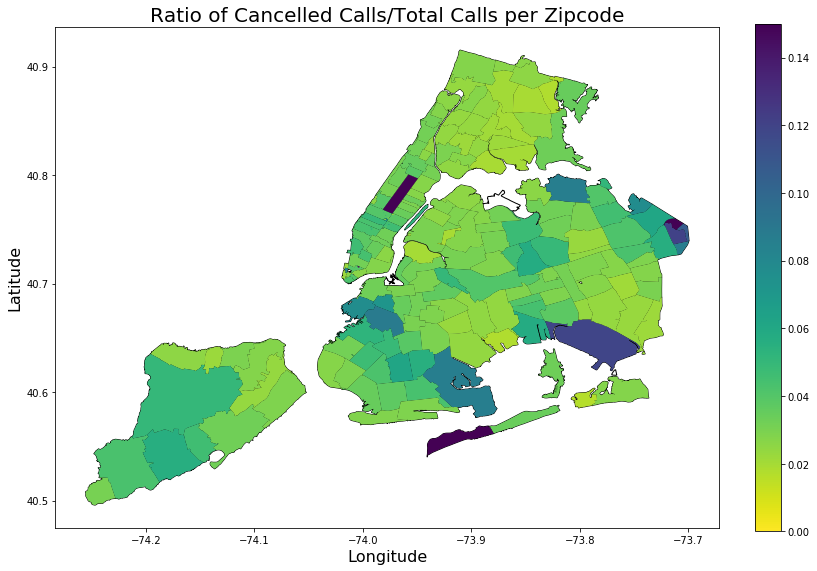

In [90]:
# Plot # of hospitals per zip
fig, ax = plt.subplots(figsize = (13, 13))
gdf.plot(ax=ax, color='white', edgecolor='black')
gdf_geo_87.plot('BOROUGH', legend=True, ax=ax,  # All df columns are identical
             cmap='viridis_r', legend_kwds={'fraction':.035}, # Scale legend height to plot
             vmin = 0,
             vmax = 0.15)
ax.set_title('Ratio of Cancelled Calls/Total Calls per Zipcode', fontsize = 20)
ax.set_xlabel('Longitude', fontsize = 16)
ax.set_ylabel('Latitude', fontsize = 16)
plt.show()

## Grouping and bar-ing

In [355]:
df_bk = df_canceled[df_canceled['BOROUGH'] == 'BROOKLYN']

In [392]:
# Only one CAD # occurred in the 11385 zipcode, which is located primarily in Queens. 
# This incident is being dropped because it skews everything else
df_bk = df_bk[df_bk['ZIPCODE'] != 11385]

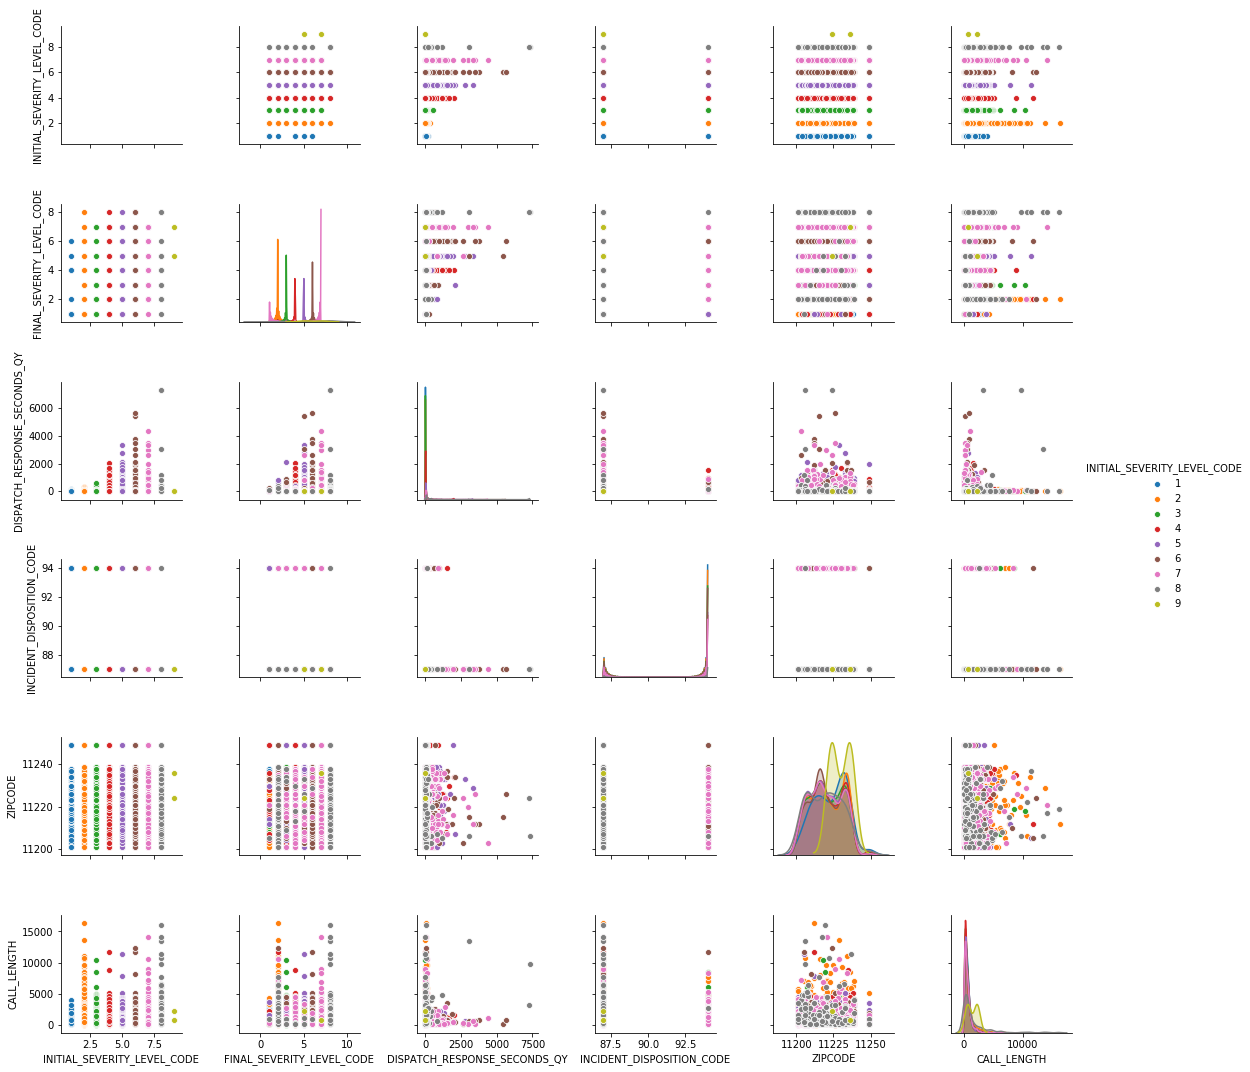

In [393]:
sns.pairplot(df_bk.drop(columns = ['INCIDENT_DATETIME',
                                  'FIRST_ASSIGNMENT_DATETIME',
                                  'FIRST_ACTIVATION_DATETIME',
                                  'FIRST_ON_SCENE_DATETIME',
                                  'FIRST_TO_HOSP_DATETIME',
                                  'FIRST_HOSP_ARRIVAL_DATETIME',
                                  'INCIDENT_CLOSE_DATETIME',
                                  'INCIDENT_RESPONSE_SECONDS_QY',
                                  'INCIDENT_TRAVEL_TM_SECONDS_QY',
                                  'CAD_INCIDENT_ID']), hue = 'INITIAL_SEVERITY_LEVEL_CODE')

In [367]:
df_bk.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH
203,183654152,2018-12-31 22:57:02,RESPIR,4,RESPIR,4,2018-12-31 22:58:17,Y,75,2018-12-31 22:58:25,2018-12-31 23:07:42,Y,640.0,565.0,NaT,NaT,2018-12-31 23:32:32,N,87,BROOKLYN,K7,11221,1490.0
274,183654073,2018-12-31 22:38:22,UNC,2,UNC,2,2018-12-31 22:38:35,Y,13,2018-12-31 22:38:49,2018-12-31 22:42:57,Y,275.0,262.0,NaT,NaT,2018-12-31 22:55:58,N,87,BROOKLYN,K4,11236,781.0
352,183653977,2018-12-31 22:14:41,UNKNOW,4,UNKNOW,4,2018-12-31 22:15:18,Y,37,2018-12-31 22:15:30,2018-12-31 22:23:26,Y,525.0,488.0,NaT,NaT,2018-12-31 22:35:52,N,87,BROOKLYN,K1,11210,746.0
412,183653901,2018-12-31 21:59:05,PEDSTR,3,PEDSTR,3,2018-12-31 21:59:13,Y,8,2018-12-31 21:59:25,2018-12-31 22:06:43,Y,458.0,450.0,NaT,NaT,2018-12-31 22:29:08,N,87,BROOKLYN,K4,11236,1345.0
435,183653875,2018-12-31 21:51:13,UNKNOW,4,UNKNOW,4,2018-12-31 21:51:35,Y,22,2018-12-31 21:51:55,2018-12-31 21:53:59,Y,166.0,144.0,NaT,NaT,2018-12-31 21:56:45,N,87,BROOKLYN,K6,11231,166.0


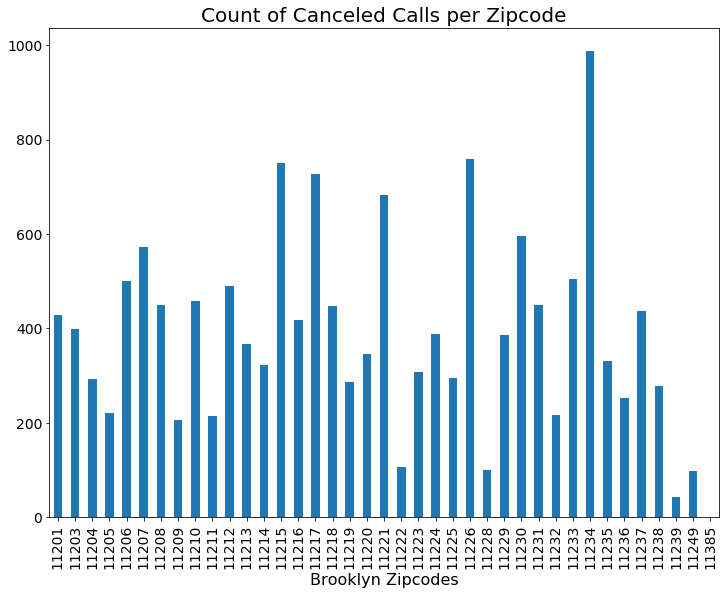

In [383]:
fig, ax = plt.subplots(figsize=(12,9))
df_bk.groupby('ZIPCODE')['CAD_INCIDENT_ID'].count().plot.bar(ax = ax);
ax.set_title('Count of Canceled Calls per Zipcode', fontsize = 20);
ax.set_xlabel('Brooklyn Zipcodes', fontsize = 16);
ax.tick_params(labelsize = 14)

In [368]:
df_bk['INITIAL_SEVERITY_LEVEL_CODE'].value_counts()

4    3692
5    2811
2    2734
3    2323
7    1626
6    1544
1     213
8     167
9       2
Name: INITIAL_SEVERITY_LEVEL_CODE, dtype: int64

In [370]:
df_bk.groupby(['ZIPCODE', 'INITIAL_SEVERITY_LEVEL_CODE']).count()

CAD_INCIDENT_ID  INCIDENT_DATETIME  \
ZIPCODE INITIAL_SEVERITY_LEVEL_CODE                                       
11201   1                                          5                  5   
        2                                         68                 68   
        3                                         42                 42   
        4                                        105                105   
        5                                         85                 85   
...                                              ...                ...   
11249   5                                          9                  9   
        6                                          6                  6   
        7                                          7                  7   
        8                                          3                  3   
11385   2                                          1                  1   

                                     INITIAL_CALL_TYPE  FINAL_CALL_TYPE  \
ZIPCODE INITIAL_SEVERITY_LEVEL_CODE                                       
11201   1                                            5                5   
        2                                           68               68   
        3                                           42               42   
        4                                          105              105   
        5                                           85               85   
...                                                ...              ...   
11249   5                                            9                9   
        6                                            6                6   
        7                                            7                7   
        8                                            3                3   
11385   2                                            1                1   

                                     FINAL_SEVERITY_LEVEL_CODE  \
ZIPCODE INITIAL_SEVERITY_LEVEL_CODE                              
11201   1                                                    5   
        2                                                   68   
        3                                                   42   
        4                                                  105   
        5                                                   85   
...                                                        ...   
11249   5                                                    9   
        6                                                    6   
        7                                                    7   
        8                                                    3   
11385   2                                                    1   

                                     FIRST_ASSIGNMENT_DATETIME  \
ZIPCODE INITIAL_SEVERITY_LEVEL_CODE                              
11201   1                                                    5   
        2                                                   68   
        3                                                   42   
        4                                                  105   
        5                                                   85   
...                                                        ...   
11249   5                                                    9   
        6                                                    6   
        7                                                    7   
        8                                                    3   
11385   2                                                    1   

                                     VALID_DISPATCH_RSPNS_TIME_INDC  \
ZIPCODE INITIAL_SEVERITY_LEVEL_CODE                                   
11201   1                                                         5   
        2                                                        68   
        3                                                        42   
        4   

## K-Modes Clustering...

In [329]:
# Thanks to https://stackoverflow.com/questions/45273731/binning-column-with-python-pandas
bins = [0, 300, 450, 600, 750, 900, 1350, 1800, 3600, 22000]
df_canceled['CALL_LENGTH_BINNED'] = pd.cut(df_canceled['CALL_LENGTH'], bins)

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [330]:
df_canceled['CALL_LENGTH_BINNED'].value_counts()

(0, 300]         13413
(300, 450]        7372
(450, 600]        5717
(900, 1350]       4958
(600, 750]        4325
(750, 900]        3102
(1800, 3600]      2079
(1350, 1800]      1879
(3600, 22000]      665
Name: CALL_LENGTH_BINNED, dtype: int64

In [331]:
df_canceled.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,CALL_LENGTH,CALL_LENGTH_BINNED
203,183654152,2018-12-31 22:57:02,RESPIR,4,RESPIR,4,2018-12-31 22:58:17,Y,75,2018-12-31 22:58:25,2018-12-31 23:07:42,Y,640.0,565.0,NaT,NaT,2018-12-31 23:32:32,N,87,BROOKLYN,K7,11221,1490.0,"(1350, 1800]"
274,183654073,2018-12-31 22:38:22,UNC,2,UNC,2,2018-12-31 22:38:35,Y,13,2018-12-31 22:38:49,2018-12-31 22:42:57,Y,275.0,262.0,NaT,NaT,2018-12-31 22:55:58,N,87,BROOKLYN,K4,11236,781.0,"(750, 900]"
352,183653977,2018-12-31 22:14:41,UNKNOW,4,UNKNOW,4,2018-12-31 22:15:18,Y,37,2018-12-31 22:15:30,2018-12-31 22:23:26,Y,525.0,488.0,NaT,NaT,2018-12-31 22:35:52,N,87,BROOKLYN,K1,11210,746.0,"(600, 750]"
412,183653901,2018-12-31 21:59:05,PEDSTR,3,PEDSTR,3,2018-12-31 21:59:13,Y,8,2018-12-31 21:59:25,2018-12-31 22:06:43,Y,458.0,450.0,NaT,NaT,2018-12-31 22:29:08,N,87,BROOKLYN,K4,11236,1345.0,"(900, 1350]"
435,183653875,2018-12-31 21:51:13,UNKNOW,4,UNKNOW,4,2018-12-31 21:51:35,Y,22,2018-12-31 21:51:55,2018-12-31 21:53:59,Y,166.0,144.0,NaT,NaT,2018-12-31 21:56:45,N,87,BROOKLYN,K6,11231,166.0,"(0, 300]"


In [332]:
df_canceled['ZIPCODE'].value_counts()

11234    987
11226    758
11215    751
11217    727
10001    706
        ... 
10278      1
10103      1
10129      1
10045      1
10107      1
Name: ZIPCODE, Length: 203, dtype: int64

In [333]:
# Get rid of all numeric/non-categorical columns
df_canceled_nonum = df_canceled.drop(columns = ['INCIDENT_DATETIME',
                                             'FINAL_CALL_TYPE',
                                             'INITIAL_SEVERITY_LEVEL_CODE',
                                             'FINAL_SEVERITY_LEVEL_CODE',
                                             'INCIDENT_DISPOSITION_CODE',
                                             'FIRST_ASSIGNMENT_DATETIME',
                                             'DISPATCH_RESPONSE_SECONDS_QY',
                                             'FIRST_ACTIVATION_DATETIME',
                                             'FIRST_ON_SCENE_DATETIME',
                                             'FIRST_TO_HOSP_DATETIME',
                                             'FIRST_HOSP_ARRIVAL_DATETIME',
                                             'INCIDENT_CLOSE_DATETIME',
                                             'HELD_INDICATOR',
                                             'INCIDENT_TRAVEL_TM_SECONDS_QY',
                                             'INCIDENT_RESPONSE_SECONDS_QY',
                                             'VALID_INCIDENT_RSPNS_TIME_INDC',
                                             'VALID_DISPATCH_RSPNS_TIME_INDC',
                                             'CALL_LENGTH'])

In [334]:
df_canceled_nonum.shape

(43520, 6)

In [335]:
df_canceled_nonum.set_index('CAD_INCIDENT_ID', inplace = True)

In [336]:
df_canceled_nonum.shape

(43520, 5)

In [337]:
df_canceled_bk = df_canceled_nonum[df_canceled_nonum['BOROUGH'] == 'BROOKLYN']

In [151]:
bk_call_topind = df_canceled_bk['INITIAL_CALL_TYPE'].value_counts()[:25].index

In [152]:
df_canceled_bk['INITIAL_CALL_TYPE'] == bk_call_topind

ValueError: Lengths must match to compare

### Dummy categorical variables

In [316]:
df_canceled_bk['INCIDENT_DISPATCH_AREA'].value_counts()

K4    2932
K6    2688
K2    2454
K1    2174
K7    2092
K3    1469
K5    1256
M3      10
M1       7
Q4       6
M5       4
M2       4
Q1       3
Q3       3
Q6       2
Q2       2
M7       1
Q7       1
M4       1
X1       1
M6       1
S1       1
Name: INCIDENT_DISPATCH_AREA, dtype: int64

In [338]:
X = pd.get_dummies(df_canceled_bk, columns = ['INITIAL_CALL_TYPE',
                                                'BOROUGH',
                                                'INCIDENT_DISPATCH_AREA', 'ZIPCODE',
                                                'CALL_LENGTH_BINNED'], drop_first = True)

In [339]:
X.shape

(15112, 140)

In [340]:
X.head()

,INITIAL_CALL_TYPE_ACC,INITIAL_CALL_TYPE_ALTMEN,INITIAL_CALL_TYPE_AMPMIN,INITIAL_CALL_TYPE_ANAPH,INITIAL_CALL_TYPE_ARREST,INITIAL_CALL_TYPE_ASTHFC,INITIAL_CALL_TYPE_ASTHMB,INITIAL_CALL_TYPE_BURNMA,INITIAL_CALL_TYPE_BURNMI,INITIAL_CALL_TYPE_CARD,INITIAL_CALL_TYPE_CARDBR,INITIAL_CALL_TYPE_CHILDA,INITIAL_CALL_TYPE_CHOKE,INITIAL_CALL_TYPE_COLD,INITIAL_CALL_TYPE_CVA,INITIAL_CALL_TYPE_CVAC,INITIAL_CALL_TYPE_DIFFBR,...,ZIPCODE_11233,ZIPCODE_11234,ZIPCODE_11235,ZIPCODE_11236,ZIPCODE_11237,ZIPCODE_11238,ZIPCODE_11239,ZIPCODE_11249,ZIPCODE_11385,"CALL_LENGTH_BINNED_(300, 450]","CALL_LENGTH_BINNED_(450, 600]","CALL_LENGTH_BINNED_(600, 750]","CALL_LENGTH_BINNED_(750, 900]","CALL_LENGTH_BINNED_(900, 1350]","CALL_LENGTH_BINNED_(1350, 1800]","CALL_LENGTH_BINNED_(1800, 3600]","CALL_LENGTH_BINNED_(3600, 22000]"
CAD_INCIDENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
183654152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
183654073,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
183653977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
183653901,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
183653875,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [320]:
kmodes

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [341]:
# Credit to https://medium.com/@davidmasse8/unsupervised-learning-for-categorical-data-dd7e497033ae
# and https://pypi.org/project/kmodes/

# define the k-modes model
km = KModes(n_clusters=10, init='Huang', n_init=11, verbose=1)

In [342]:
# fit the clusters to the skills dataframe
clusters = km.fit_predict(X)
# get an array of cluster modes
kmodes = km.cluster_centroids_
shape = kmodes.shape
# For each cluster mode (a vector of "1" and "0")
# find and print the column headings where "1" appears.
# If no "1" appears, assign to "no-skills" cluster.
for i in range(shape[0]):
    if sum(kmodes[i,:]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-skills cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i,:]
        for j in X.columns[np.nonzero(cent)]:
            print(j)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3576, cost: 42841.0
Run 1, iteration: 2/100, moves: 226, cost: 42841.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 5212, cost: 42316.0
Run 2, iteration: 2/100, moves: 17, cost: 42316.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 6455, cost: 42596.0
Run 3, iteration: 2/100, moves: 25, cost: 42596.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 3452, cost: 42162.0
Run 4, iteration: 2/100, moves: 0, cost: 42162.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 4911, cost: 41612.0
Run 5, iteration: 2/100, moves: 230, cost: 41612.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, it

In [343]:
# define the k-modes model
km = KModes(n_clusters=12, init='Huang', n_init=11, verbose=1)

# fit the clusters to the skills dataframe
clusters = km.fit_predict(X)

# get an array of cluster modes
kmodes = km.cluster_centroids_
shape = kmodes.shape

# For each cluster mode (a vector of "1" and "0")
# find and print the column headings where "1" appears.
# If no "1" appears, assign to "no-skills" cluster.
for i in range(shape[0]):
    if sum(kmodes[i,:]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-skills cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i,:]
        for j in X.columns[np.nonzero(cent)]:
            print(j)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5181, cost: 40600.0
Run 1, iteration: 2/100, moves: 240, cost: 40600.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4308, cost: 40466.0
Run 2, iteration: 2/100, moves: 332, cost: 40466.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 5465, cost: 40712.0
Run 3, iteration: 2/100, moves: 340, cost: 40712.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 4174, cost: 40035.0
Run 4, iteration: 2/100, moves: 272, cost: 40035.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 7287, cost: 41110.0
Run 5, iteration: 2/100, moves: 2078, cost: 41110.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 

## Prior work

In [4]:
df.tail()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
52479,130010006,01/01/2013 12:01:26 AM,INJURY,5,INJURY,5,01/01/2013 12:01:58 AM,Y,32,01/01/2013 12:02:55 AM,01/01/2013 12:15:42 AM,Y,856.0,824.0,01/01/2013 12:27:42 AM,01/01/2013 12:31:13 AM,01/01/2013 12:53:12 AM,N,82.0,BRONX,B2,10457.0,48.0,15.0,206.0,10.0,15.0,N,N,N,N
52480,130010005,01/01/2013 12:01:16 AM,SICK,6,SICK,6,01/01/2013 12:02:12 AM,Y,56,01/01/2013 12:02:55 AM,01/01/2013 12:15:04 AM,Y,828.0,772.0,01/01/2013 12:34:54 AM,01/01/2013 12:53:02 AM,01/01/2013 01:20:28 AM,N,82.0,BRONX,B2,10453.0,46.0,14.0,205.0,10.0,15.0,N,N,N,N
52481,130010004,01/01/2013 12:01:04 AM,ARREST,1,ARREST,1,01/01/2013 12:01:33 AM,Y,29,01/01/2013 12:01:58 AM,01/01/2013 12:08:13 AM,Y,429.0,400.0,NaN,NaN,01/01/2013 12:38:05 AM,N,83.0,QUEENS,Q3,11418.0,102.0,29.0,409.0,27.0,5.0,N,N,N,N
52482,130010002,01/01/2013 12:00:19 AM,CARD,3,CARD,3,01/01/2013 12:01:18 AM,Y,59,01/01/2013 12:02:08 AM,01/01/2013 12:14:30 AM,Y,851.0,792.0,NaN,NaN,01/01/2013 12:55:34 AM,N,93.0,BRONX,B1,10454.0,40.0,8.0,201.0,7.0,15.0,N,N,N,N
52483,130010001,01/01/2013 12:00:04 AM,RESPIR,4,RESPIR,4,01/01/2013 12:01:45 AM,Y,101,01/01/2013 12:01:51 AM,01/01/2013 12:13:21 AM,Y,797.0,696.0,01/01/2013 12:28:49 AM,01/01/2013 12:38:15 AM,01/01/2013 01:04:56 AM,N,82.0,BRONX,B3,10472.0,43.0,18.0,209.0,12.0,15.0,N,N,N,N


In [8]:
# resulting df is same size as original df, no duplicates found
df.drop_duplicates().compute()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
0,183654386,12/31/2018 11:59:46 PM,CARDBR,2,CARDBR,2,12/31/2018 11:59:54 PM,Y,8,01/01/2019 12:00:51 AM,01/01/2019 12:07:27 AM,Y,461.0,453.0,01/01/2019 12:15:08 AM,01/01/2019 12:21:51 AM,01/01/2019 01:00:20 AM,N,82.0,BROOKLYN,K6,11201.0,84.0,35.0,302.0,13.0,8.0,N,N,N,N
1,183654385,12/31/2018 11:59:20 PM,MVAINJ,4,MVAINJ,4,01/01/2019 12:01:10 AM,Y,110,01/01/2019 12:02:25 AM,01/01/2019 12:07:19 AM,Y,479.0,369.0,NaN,NaN,01/01/2019 12:19:49 AM,N,91.0,QUEENS,Q3,11416.0,102.0,32.0,409.0,27.0,7.0,N,N,N,N
2,183654384,12/31/2018 11:58:45 PM,SICK,6,SICK,6,01/01/2019 12:00:43 AM,Y,118,01/01/2019 12:02:08 AM,01/01/2019 12:14:18 AM,Y,933.0,815.0,01/01/2019 12:23:59 AM,01/01/2019 12:34:07 AM,01/01/2019 01:21:30 AM,N,82.0,QUEENS,Q6,11369.0,115.0,21.0,480.0,30.0,14.0,N,N,N,N
3,183654383,12/31/2018 11:58:14 PM,INJMAJ,3,INJMAJ,3,12/31/2018 11:58:22 PM,Y,8,12/31/2018 11:58:37 PM,01/01/2019 12:04:10 AM,Y,356.0,348.0,01/01/2019 01:06:29 AM,01/01/2019 01:15:30 AM,01/01/2019 02:02:12 AM,N,82.0,BROOKLYN,K1,11214.0,62.0,47.0,311.0,20.0,11.0,N,N,N,N
4,183654382,12/31/2018 11:57:42 PM,UNC,2,UNC,2,01/01/2019 12:00:39 AM,Y,177,01/01/2019 12:01:03 AM,01/01/2019 12:15:00 AM,Y,1038.0,861.0,01/01/2019 01:18:22 AM,01/01/2019 01:22:01 AM,01/01/2019 02:34:19 AM,N,82.0,MANHATTAN,M3,10019.0,18.0,4.0,105.0,2.0,12.0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52479,130010006,01/01/2013 12:01:26 AM,INJURY,5,INJURY,5,01/01/2013 12:01:58 AM,Y,32,01/01/2013 12:02:55 AM,01/01/2013 12:15:42 AM,Y,856.0,824.0,01/01/2013 12:27:42 AM,01/01/2013 12:31:13 AM,01/01/2013 12:53:12 AM,N,82.0,BRONX,B2,10457.0,48.0,15.0,206.0,10.0,15.0,N,N,N,N
52480,130010005,01/01/2013 12:01:16 AM,SICK,6,SICK,6,01/01/2013 12:02:12 AM,Y,56,01/01/2013 12:02:55 AM,01/01/2013 12:15:04 AM,Y,828.0,772.0,01/01/2013 12:34:54 AM,01/01/2013 12:53:02 AM,01/01/2013 01:20:28 AM,N,82.0,BRONX,B2,10453.0,46.0,14.0,205.0,10.0,15.0,N,N,N,N
52481,130010004,01/01/2013 12:01:04 AM,ARREST,1,ARREST,1,01/01/2013 12:01:33 AM,Y,29,01/01/2013 12:01:58 AM,01/01/2013 12:08:13 AM,Y,429.0,400.0,NaN,NaN,01/01/2013 12:38:05 AM,N,83.0,QUEENS,Q3,11418.0,102.0,29.0,409.0,27.0,5.0,N,N,N,N
52482,130010002,01/01/2013 12:00:19 AM,CARD,3,CARD,3,01/01/2013 12:01:18 AM,Y,59,01/01/2013 12:02:08 AM,01/01/2013 12:14:30 AM,Y,851.0,792.0,NaN,NaN,01/01/2013 12:55:34 AM,N,93.0,BRONX,B1,10454.0,40.0,8.0,201.0,7.0,15.0,N,N,N,N


In [5]:
df.compute()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
0,183654386,12/31/2018 11:59:46 PM,CARDBR,2,CARDBR,2,12/31/2018 11:59:54 PM,Y,8,01/01/2019 12:00:51 AM,01/01/2019 12:07:27 AM,Y,461.0,453.0,01/01/2019 12:15:08 AM,01/01/2019 12:21:51 AM,01/01/2019 01:00:20 AM,N,82.0,BROOKLYN,K6,11201.0,84.0,35.0,302.0,13.0,8.0,N,N,N,N
1,183654385,12/31/2018 11:59:20 PM,MVAINJ,4,MVAINJ,4,01/01/2019 12:01:10 AM,Y,110,01/01/2019 12:02:25 AM,01/01/2019 12:07:19 AM,Y,479.0,369.0,NaN,NaN,01/01/2019 12:19:49 AM,N,91.0,QUEENS,Q3,11416.0,102.0,32.0,409.0,27.0,7.0,N,N,N,N
2,183654384,12/31/2018 11:58:45 PM,SICK,6,SICK,6,01/01/2019 12:00:43 AM,Y,118,01/01/2019 12:02:08 AM,01/01/2019 12:14:18 AM,Y,933.0,815.0,01/01/2019 12:23:59 AM,01/01/2019 12:34:07 AM,01/01/2019 01:21:30 AM,N,82.0,QUEENS,Q6,11369.0,115.0,21.0,480.0,30.0,14.0,N,N,N,N
3,183654383,12/31/2018 11:58:14 PM,INJMAJ,3,INJMAJ,3,12/31/2018 11:58:22 PM,Y,8,12/31/2018 11:58:37 PM,01/01/2019 12:04:10 AM,Y,356.0,348.0,01/01/2019 01:06:29 AM,01/01/2019 01:15:30 AM,01/01/2019 02:02:12 AM,N,82.0,BROOKLYN,K1,11214.0,62.0,47.0,311.0,20.0,11.0,N,N,N,N
4,183654382,12/31/2018 11:57:42 PM,UNC,2,UNC,2,01/01/2019 12:00:39 AM,Y,177,01/01/2019 12:01:03 AM,01/01/2019 12:15:00 AM,Y,1038.0,861.0,01/01/2019 01:18:22 AM,01/01/2019 01:22:01 AM,01/01/2019 02:34:19 AM,N,82.0,MANHATTAN,M3,10019.0,18.0,4.0,105.0,2.0,12.0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52479,130010006,01/01/2013 12:01:26 AM,INJURY,5,INJURY,5,01/01/2013 12:01:58 AM,Y,32,01/01/2013 12:02:55 AM,01/01/2013 12:15:42 AM,Y,856.0,824.0,01/01/2013 12:27:42 AM,01/01/2013 12:31:13 AM,01/01/2013 12:53:12 AM,N,82.0,BRONX,B2,10457.0,48.0,15.0,206.0,10.0,15.0,N,N,N,N
52480,130010005,01/01/2013 12:01:16 AM,SICK,6,SICK,6,01/01/2013 12:02:12 AM,Y,56,01/01/2013 12:02:55 AM,01/01/2013 12:15:04 AM,Y,828.0,772.0,01/01/2013 12:34:54 AM,01/01/2013 12:53:02 AM,01/01/2013 01:20:28 AM,N,82.0,BRONX,B2,10453.0,46.0,14.0,205.0,10.0,15.0,N,N,N,N
52481,130010004,01/01/2013 12:01:04 AM,ARREST,1,ARREST,1,01/01/2013 12:01:33 AM,Y,29,01/01/2013 12:01:58 AM,01/01/2013 12:08:13 AM,Y,429.0,400.0,NaN,NaN,01/01/2013 12:38:05 AM,N,83.0,QUEENS,Q3,11418.0,102.0,29.0,409.0,27.0,5.0,N,N,N,N
52482,130010002,01/01/2013 12:00:19 AM,CARD,3,CARD,3,01/01/2013 12:01:18 AM,Y,59,01/01/2013 12:02:08 AM,01/01/2013 12:14:30 AM,Y,851.0,792.0,NaN,NaN,01/01/2013 12:55:34 AM,N,93.0,BRONX,B1,10454.0,40.0,8.0,201.0,7.0,15.0,N,N,N,N


In [7]:
# Where does .describe() actually do something useful here/which numeric columns actually contain continous data?
df.describe().compute()

,CAD_INCIDENT_ID,INITIAL_SEVERITY_LEVEL_CODE,FINAL_SEVERITY_LEVEL_CODE,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,INCIDENT_DISPOSITION_CODE,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT
count,8.557848e+06,8.557848e+06,8.557848e+06,8.557848e+06,8.283276e+06,8.284535e+06,8.487996e+06,8.393452e+06,8.393762e+06,8.390614e+06,8.393756e+06,8.389424e+06,8.390614e+06
mean,1.576735e+08,4.277234e+00,4.171099e+00,9.126130e+01,5.640595e+02,4.744960e+02,8.473824e+01,1.073609e+04,6.159616e+01,2.303020e+01,2.610761e+02,1.471603e+01,1.063469e+01
std,1.706354e+07,1.691518e+00,1.701282e+00,5.324385e+02,6.698499e+02,3.726474e+02,4.558447e+00,5.496244e+02,3.409391e+01,1.498240e+01,1.178349e+02,9.594994e+00,3.336092e+00
min,1.300100e+08,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.200000e+01,8.300000e+01,1.000000e+00,1.000000e+00,1.010000e+02,1.000000e+00,3.000000e+00
25%,1.501509e+08,3.000000e+00,3.000000e+00,1.600000e+01,3.280000e+02,2.950000e+02,8.200000e+01,1.030400e+04,4.000000e+01,1.000000e+01,2.010000e+02,7.000000e+00,8.000000e+00
50%,1.701227e+08,5.000000e+00,4.000000e+00,2.700000e+01,4.680000e+02,4.280000e+02,8.200000e+01,1.047300e+04,6.200000e+01,2.100000e+01,3.020000e+02,1.400000e+01,1.100000e+01
75%,1.834902e+08,6.000000e+00,6.000000e+00,5.700000e+01,6.990000e+02,6.300000e+02,9.000000e+01,1.122600e+04,9.000000e+01,3.700000e+01,3.180000e+02,2.300000e+01,1.300000e+01
max,1.836544e+08,9.000000e+00,8.000000e+00,3.233200e+04,3.237700e+04,9.539000e+04,9.600000e+01,1.234500e+04,1.230000e+02,5.100000e+01,5.950000e+02,3.200000e+01,1.600000e+01


**Note:** Most of these numeric variables are _NOT_ continuous-
* CAD_INCIDENT_ID = unique ID for each dispatched incident
* INITIAL/FINAL_SEVERITY_LEVEL_CODE = categorical ranking of severity
* Time-variables = mostly continuous
* INCIDENT_DISPOSITION_CODE = 

In [10]:
df.groupby('INCIDENT_DISPOSITION_CODE').mean().compute()

,CAD_INCIDENT_ID,INITIAL_SEVERITY_LEVEL_CODE,FINAL_SEVERITY_LEVEL_CODE,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT
INCIDENT_DISPOSITION_CODE,,,,,,,,,,,,
82.0,1.574981e+08,4.211062,4.094433,73.657820,540.484035,466.868686,10747.328383,62.392340,23.343400,263.660966,14.916679,10.627929
83.0,1.574779e+08,1.543490,1.247004,30.694798,336.687017,306.023545,10821.249078,68.490727,25.332592,286.452565,16.816770,10.176383
87.0,1.539286e+08,4.519001,4.426052,193.128791,703.040104,510.703580,10746.312499,61.524448,23.174964,261.901409,14.738466,10.328032
90.0,1.582946e+08,4.613199,4.539752,131.217250,635.069396,505.642640,10697.356831,59.022301,21.808548,252.001293,14.013083,10.688138
91.0,1.619979e+08,4.653206,4.575987,337.484423,808.025232,488.099582,10827.726319,68.991843,24.944326,287.684550,16.778780,10.239166
92.0,1.594170e+08,4.553571,4.517857,93.660714,617.568627,516.960784,10755.446429,66.214286,23.500000,275.375000,15.714286,10.285714
93.0,1.588346e+08,4.245094,4.176672,77.272408,540.835387,463.618494,10713.008404,59.879226,22.610034,256.085528,14.356958,10.673308
94.0,1.567447e+08,3.977168,3.849081,82.790207,536.641007,454.351135,10896.169441,71.431034,28.266875,300.923454,17.785661,9.456586
95.0,1.583343e+08,4.639163,4.567734,121.552956,628.980100,506.967662,10358.412639,31.023544,11.376704,174.112763,7.337051,8.477076


In [32]:
df['INCIDENT_DISPOSITION_CODE'].value_counts().compute()

82.0    6037089
93.0     970026
90.0     748772
96.0     299626
87.0     265585
91.0     100662
83.0      58404
94.0       6964
95.0        812
92.0         56
Name: INCIDENT_DISPOSITION_CODE, dtype: int64

In [33]:
df['INCIDENT_DISPOSITION_CODE'].value_counts().sum().compute()

8487996

In [31]:
# What are the unique values for INCIDENT_DISPOSITION_CODE?
df['INCIDENT_DISPOSITION_CODE'].unique().compute()

0     82.0
1     91.0
2     93.0
3     90.0
4     96.0
5      NaN
6     87.0
7     83.0
8     94.0
9     95.0
10    92.0
Name: INCIDENT_DISPOSITION_CODE, dtype: float64

In [35]:
# How many NaNs are there for the INCIDENT_DISPOSITION_CODE??? 69_852
df['INCIDENT_DISPOSITION_CODE'].isna().sum().compute()

69852

In [17]:
df.count().compute()

CAD_INCIDENT_ID                   8557848
INCIDENT_DATETIME                 8557848
INITIAL_CALL_TYPE                 8557848
INITIAL_SEVERITY_LEVEL_CODE       8557848
FINAL_CALL_TYPE                   8557848
FINAL_SEVERITY_LEVEL_CODE         8557848
FIRST_ASSIGNMENT_DATETIME         8498783
VALID_DISPATCH_RSPNS_TIME_INDC    8557848
DISPATCH_RESPONSE_SECONDS_QY      8557848
FIRST_ACTIVATION_DATETIME         8483588
FIRST_ON_SCENE_DATETIME           8284662
VALID_INCIDENT_RSPNS_TIME_INDC    8557848
INCIDENT_RESPONSE_SECONDS_QY      8283276
INCIDENT_TRAVEL_TM_SECONDS_QY     8284535
FIRST_TO_HOSP_DATETIME            6031607
FIRST_HOSP_ARRIVAL_DATETIME       5990574
INCIDENT_CLOSE_DATETIME           8554621
HELD_INDICATOR                    8557848
INCIDENT_DISPOSITION_CODE         8487996
BOROUGH                           8557848
INCIDENT_DISPATCH_AREA            8557848
ZIPCODE                           8393452
POLICEPRECINCT                    8393762
CITYCOUNCILDISTRICT               

In [18]:
df[(df['INCIDENT_DISPOSITION_CODE'] == 87)].compute()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
207,183654152,12/31/2018 10:57:02 PM,RESPIR,4,RESPIR,4,12/31/2018 10:58:17 PM,Y,75,12/31/2018 10:58:25 PM,12/31/2018 11:07:42 PM,Y,640.0,565.0,NaN,NaN,12/31/2018 11:32:32 PM,N,87.0,BROOKLYN,K7,11221.0,83.0,37.0,304.0,32.0,7.0,N,N,N,N
267,183654085,12/31/2018 10:41:01 PM,UNKNOW,4,UNKNOW,4,12/31/2018 10:42:25 PM,Y,84,12/31/2018 10:43:07 PM,NaN,N,NaN,NaN,NaN,NaN,12/31/2018 10:46:33 PM,N,87.0,MANHATTAN,M3,10022.0,17.0,4.0,106.0,2.0,12.0,N,N,N,N
279,183654073,12/31/2018 10:38:22 PM,UNC,2,UNC,2,12/31/2018 10:38:35 PM,Y,13,12/31/2018 10:38:49 PM,12/31/2018 10:42:57 PM,Y,275.0,262.0,NaN,NaN,12/31/2018 10:55:58 PM,N,87.0,BROOKLYN,K4,11236.0,69.0,46.0,318.0,18.0,8.0,N,N,N,N
323,183654022,12/31/2018 10:25:55 PM,UNKNOW,4,UNKNOW,4,12/31/2018 10:26:10 PM,Y,15,12/31/2018 10:26:22 PM,NaN,N,NaN,NaN,NaN,NaN,12/31/2018 10:31:45 PM,N,87.0,BROOKLYN,K5,11216.0,79.0,36.0,303.0,13.0,8.0,N,N,N,N
349,183653988,12/31/2018 10:17:05 PM,DRUG,4,DRUG,4,12/31/2018 10:17:21 PM,Y,16,12/31/2018 10:17:30 PM,NaN,N,NaN,NaN,NaN,NaN,12/31/2018 10:18:10 PM,N,87.0,BROOKLYN,K7,11211.0,90.0,34.0,301.0,14.0,7.0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52393,130010100,01/01/2013 12:24:24 AM,UNC,2,UNC,2,01/01/2013 12:26:04 AM,Y,100,01/01/2013 12:26:33 AM,01/01/2013 12:33:17 AM,Y,533.0,433.0,NaN,NaN,01/01/2013 12:48:42 AM,N,87.0,MANHATTAN,M2,10010.0,13.0,4.0,106.0,2.0,12.0,N,N,N,N
52411,130010081,01/01/2013 12:20:12 AM,SEIZR,3,SEIZR,3,01/01/2013 12:24:11 AM,Y,239,01/01/2013 12:24:11 AM,01/01/2013 12:26:59 AM,Y,407.0,168.0,NaN,NaN,01/01/2013 12:50:17 AM,Y,87.0,MANHATTAN,M3,10036.0,14.0,3.0,104.0,2.0,10.0,N,N,N,N
52433,130010057,01/01/2013 12:14:43 AM,ABDPN,5,ABDPN,5,01/01/2013 12:31:49 AM,Y,1026,01/01/2013 12:31:49 AM,01/01/2013 01:03:10 AM,Y,2907.0,1881.0,NaN,NaN,01/01/2013 01:16:44 AM,Y,87.0,MANHATTAN,M3,10019.0,18.0,3.0,104.0,2.0,10.0,N,N,N,N
52448,130010039,01/01/2013 12:09:57 AM,UNKNOW,4,UNKNOW,4,01/01/2013 12:10:13 AM,Y,16,01/01/2013 12:10:25 AM,01/01/2013 12:23:28 AM,Y,811.0,795.0,NaN,NaN,01/01/2013 12:26:22 AM,N,87.0,RICHMOND / STATEN ISLAND,S1,10303.0,121.0,49.0,501.0,31.0,11.0,N,N,N,N


In [19]:
df_87 = df[(df['INCIDENT_DISPOSITION_CODE'] == 87)].compute()

In [22]:
df.groupby('ZIPCODE').count().compute()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
ZIPCODE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000.0,927,927,927,927,927,927,912,927,927,910,854,927,853,854,444,431,927,927,912,927,927,927,927,927,927,927,927,927,927,927
10001.0,101271,101271,101271,101271,101271,101271,100475,101271,101271,100274,97207,101271,97202,97207,64917,64410,101236,101271,100306,101271,101271,101271,101271,101271,101271,101271,101271,101271,101271,101271
10002.0,100970,100970,100970,100970,100970,100970,100322,100970,100970,100147,97804,100970,97797,97801,70033,69673,100935,100970,100208,100970,100970,100970,100970,100970,100625,100970,100970,100970,100970,100970
10003.0,87305,87305,87305,87305,87305,87305,86534,87305,87305,86319,84018,87305,84007,84013,54699,54370,87274,87305,86407,87305,87305,87305,87305,87305,87305,87305,87305,87305,87305,87305
10004.0,13278,13278,13278,13278,13278,13278,13155,13278,13278,13109,12692,13278,12687,12692,8860,8825,13275,13278,13138,13278,13278,13278,13278,13278,13278,13278,13278,13278,13278,13278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10167.0,34,34,34,34,34,34,34,34,34,34,33,34,33,33,25,25,34,34,34,34,34,34,34,34,34,34,34,34,34,34
10176.0,25,25,25,25,25,25,25,25,25,24,24,25,24,24,16,16,25,25,24,25,25,25,25,25,25,25,25,25,25,25
83.0,22,22,22,22,22,22,22,22,22,22,20,22,20,20,9,9,22,22,22,22,22,22,22,22,22,22,22,22,22,22


In [20]:
df_87.groupby('ZIPCODE').count()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
ZIPCODE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
83.0,5,5,5,5,5,5,5,5,5,5,4,5,4,4,0,0,5,5,5,5,5,5,5,5,5,5,5,5,5,5
10000.0,125,125,125,125,125,125,125,125,125,123,87,125,87,87,0,0,125,125,125,125,125,125,125,125,125,125,125,125,125,125
10001.0,4181,4181,4181,4181,4181,4181,4181,4181,4181,4110,2556,4181,2553,2556,13,7,4181,4181,4181,4181,4181,4181,4181,4181,4181,4181,4181,4181,4181,4181
10002.0,2497,2497,2497,2497,2497,2497,2497,2497,2497,2424,1347,2497,1346,1347,5,5,2496,2497,2497,2497,2497,2497,2497,2497,2460,2497,2497,2497,2497,2497
10003.0,2879,2879,2879,2879,2879,2879,2879,2879,2879,2798,1692,2879,1690,1692,10,3,2877,2879,2879,2879,2879,2879,2879,2879,2879,2879,2879,2879,2879,2879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11692.0,429,429,429,429,429,429,429,429,429,414,267,429,266,267,1,0,429,429,429,429,429,429,429,429,429,429,429,429,429,429
11693.0,560,560,560,560,560,560,560,560,560,554,369,560,368,369,1,0,560,560,560,560,560,560,560,560,558,560,560,560,560,560
11694.0,577,577,577,577,577,577,577,577,577,562,397,577,395,397,0,0,577,577,577,577,577,577,577,577,577,577,577,577,577,577


In [23]:
df.tail()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
52479,130010006,01/01/2013 12:01:26 AM,INJURY,5,INJURY,5,01/01/2013 12:01:58 AM,Y,32,01/01/2013 12:02:55 AM,01/01/2013 12:15:42 AM,Y,856.0,824.0,01/01/2013 12:27:42 AM,01/01/2013 12:31:13 AM,01/01/2013 12:53:12 AM,N,82.0,BRONX,B2,10457.0,48.0,15.0,206.0,10.0,15.0,N,N,N,N
52480,130010005,01/01/2013 12:01:16 AM,SICK,6,SICK,6,01/01/2013 12:02:12 AM,Y,56,01/01/2013 12:02:55 AM,01/01/2013 12:15:04 AM,Y,828.0,772.0,01/01/2013 12:34:54 AM,01/01/2013 12:53:02 AM,01/01/2013 01:20:28 AM,N,82.0,BRONX,B2,10453.0,46.0,14.0,205.0,10.0,15.0,N,N,N,N
52481,130010004,01/01/2013 12:01:04 AM,ARREST,1,ARREST,1,01/01/2013 12:01:33 AM,Y,29,01/01/2013 12:01:58 AM,01/01/2013 12:08:13 AM,Y,429.0,400.0,NaN,NaN,01/01/2013 12:38:05 AM,N,83.0,QUEENS,Q3,11418.0,102.0,29.0,409.0,27.0,5.0,N,N,N,N
52482,130010002,01/01/2013 12:00:19 AM,CARD,3,CARD,3,01/01/2013 12:01:18 AM,Y,59,01/01/2013 12:02:08 AM,01/01/2013 12:14:30 AM,Y,851.0,792.0,NaN,NaN,01/01/2013 12:55:34 AM,N,93.0,BRONX,B1,10454.0,40.0,8.0,201.0,7.0,15.0,N,N,N,N
52483,130010001,01/01/2013 12:00:04 AM,RESPIR,4,RESPIR,4,01/01/2013 12:01:45 AM,Y,101,01/01/2013 12:01:51 AM,01/01/2013 12:13:21 AM,Y,797.0,696.0,01/01/2013 12:28:49 AM,01/01/2013 12:38:15 AM,01/01/2013 01:04:56 AM,N,82.0,BRONX,B3,10472.0,43.0,18.0,209.0,12.0,15.0,N,N,N,N


In [ ]:
df.get_partition(0).compute()

### Identify calls/year in dask dataframe

In [25]:
# of calls in 2013 = 1_314_692
df[(df['CAD_INCIDENT_ID'] > 130000000) & (df['CAD_INCIDENT_ID'] < 140000000)].compute()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
108536,133653553,12/31/2013 11:59:50 PM,UNKNOW,4,UNKNOW,4,01/01/2014 12:00:25 AM,Y,35,01/01/2014 12:00:39 AM,01/01/2014 12:14:19 AM,Y,869.0,834.0,NaN,NaN,01/01/2014 12:27:16 AM,N,90.0,BROOKLYN,K4,11208.0,75.0,37.0,305.0,19.0,7.0,N,N,N,N
108537,133653552,12/31/2013 11:59:38 PM,INJURY,5,INJURY,5,01/01/2014 12:00:04 AM,Y,26,01/01/2014 12:00:12 AM,01/01/2014 12:03:47 AM,Y,249.0,223.0,01/01/2014 12:21:13 AM,01/01/2014 12:47:06 AM,01/01/2014 12:47:38 AM,N,82.0,MANHATTAN,M2,10010.0,13.0,3.0,105.0,2.0,12.0,N,N,N,N
108538,133653551,12/31/2013 11:58:22 PM,DIFFBR,2,DIFFBR,2,12/31/2013 11:58:42 PM,Y,20,12/31/2013 11:58:50 PM,01/01/2014 12:02:29 AM,Y,247.0,227.0,01/01/2014 12:23:10 AM,01/01/2014 12:32:45 AM,01/01/2014 12:48:10 AM,N,82.0,BROOKLYN,K7,11249.0,90.0,33.0,301.0,14.0,7.0,N,N,N,N
108539,133653550,12/31/2013 11:57:52 PM,SICK,6,SICK,6,12/31/2013 11:58:45 PM,Y,53,12/31/2013 11:58:58 PM,01/01/2014 12:05:46 AM,Y,474.0,421.0,NaN,NaN,01/01/2014 12:30:41 AM,N,93.0,QUEENS,Q3,11416.0,102.0,32.0,409.0,27.0,7.0,N,N,N,N
108540,133653549,12/31/2013 11:57:40 PM,SHOT,3,SHOT,3,12/31/2013 11:58:11 PM,Y,31,12/31/2013 11:58:20 PM,01/01/2014 12:03:04 AM,Y,324.0,293.0,NaN,NaN,01/01/2014 12:19:43 AM,N,90.0,QUEENS,Q2,11413.0,105.0,31.0,413.0,29.0,5.0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52479,130010006,01/01/2013 12:01:26 AM,INJURY,5,INJURY,5,01/01/2013 12:01:58 AM,Y,32,01/01/2013 12:02:55 AM,01/01/2013 12:15:42 AM,Y,856.0,824.0,01/01/2013 12:27:42 AM,01/01/2013 12:31:13 AM,01/01/2013 12:53:12 AM,N,82.0,BRONX,B2,10457.0,48.0,15.0,206.0,10.0,15.0,N,N,N,N
52480,130010005,01/01/2013 12:01:16 AM,SICK,6,SICK,6,01/01/2013 12:02:12 AM,Y,56,01/01/2013 12:02:55 AM,01/01/2013 12:15:04 AM,Y,828.0,772.0,01/01/2013 12:34:54 AM,01/01/2013 12:53:02 AM,01/01/2013 01:20:28 AM,N,82.0,BRONX,B2,10453.0,46.0,14.0,205.0,10.0,15.0,N,N,N,N
52481,130010004,01/01/2013 12:01:04 AM,ARREST,1,ARREST,1,01/01/2013 12:01:33 AM,Y,29,01/01/2013 12:01:58 AM,01/01/2013 12:08:13 AM,Y,429.0,400.0,NaN,NaN,01/01/2013 12:38:05 AM,N,83.0,QUEENS,Q3,11418.0,102.0,29.0,409.0,27.0,5.0,N,N,N,N
52482,130010002,01/01/2013 12:00:19 AM,CARD,3,CARD,3,01/01/2013 12:01:18 AM,Y,59,01/01/2013 12:02:08 AM,01/01/2013 12:14:30 AM,Y,851.0,792.0,NaN,NaN,01/01/2013 12:55:34 AM,N,93.0,BRONX,B1,10454.0,40.0,8.0,201.0,7.0,15.0,N,N,N,N


In [26]:
# of calls in 2014 = 1_357_418
df[(df['CAD_INCIDENT_ID'] > 140000000) & (df['CAD_INCIDENT_ID'] < 150000000)].compute()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
122235,143653765,12/31/2014 11:58:55 PM,ABDPN,5,ABDPN,5,12/31/2014 11:59:45 PM,Y,50,01/01/2015 12:00:02 AM,01/01/2015 12:09:45 AM,Y,650.0,600.0,01/01/2015 12:24:20 AM,01/01/2015 12:34:41 AM,01/01/2015 01:03:41 AM,N,82.0,BROOKLYN,K4,11236.0,69.0,42.0,318.0,18.0,8.0,N,N,N,N
122236,143653764,12/31/2014 11:58:51 PM,INJURY,5,INJURY,5,01/01/2015 12:25:30 AM,Y,1599,01/01/2015 12:25:30 AM,NaN,N,NaN,NaN,NaN,NaN,01/01/2015 12:42:53 AM,Y,90.0,MANHATTAN,M3,10019.0,18.0,4.0,105.0,2.0,12.0,N,N,N,N
122237,143653763,12/31/2014 11:58:50 PM,UNC,2,UNC,2,01/01/2015 12:01:20 AM,Y,150,01/01/2015 12:01:36 AM,01/01/2015 12:04:07 AM,Y,317.0,167.0,01/01/2015 12:22:42 AM,01/01/2015 12:31:06 AM,01/01/2015 01:00:22 AM,N,82.0,MANHATTAN,M2,10011.0,10.0,3.0,104.0,2.0,10.0,N,N,N,N
122238,143653762,12/31/2014 11:58:22 PM,INJURY,5,INJURY,5,12/31/2014 11:59:15 PM,Y,53,12/31/2014 11:59:27 PM,01/01/2015 12:04:27 AM,Y,365.0,312.0,NaN,NaN,01/01/2015 12:17:14 AM,N,96.0,MANHATTAN,M1,NaN,NaN,NaN,NaN,NaN,NaN,N,N,N,N
122239,143653761,12/31/2014 11:58:18 PM,INJURY,4,INJURY,4,12/31/2014 11:58:54 PM,Y,36,12/31/2014 11:59:00 PM,01/01/2015 12:05:33 AM,Y,435.0,399.0,01/01/2015 12:16:47 AM,01/01/2015 12:25:42 AM,01/01/2015 12:39:59 AM,N,82.0,BROOKLYN,K2,11218.0,70.0,44.0,314.0,20.0,10.0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108531,140010005,01/01/2014 12:01:47 AM,ABDPN,5,RESPIR,4,01/01/2014 12:19:28 AM,Y,1061,01/01/2014 12:19:34 AM,01/01/2014 12:27:21 AM,Y,1534.0,473.0,NaN,NaN,01/01/2014 12:28:28 AM,Y,87.0,BRONX,B4,10467.0,49.0,15.0,211.0,11.0,14.0,N,N,N,N
108532,140010004,01/01/2014 12:01:07 AM,OTHER,6,OTHER,6,01/01/2014 12:02:44 AM,Y,97,01/01/2014 12:04:23 AM,01/01/2014 12:13:34 AM,Y,747.0,650.0,01/01/2014 12:37:18 AM,01/01/2014 12:45:42 AM,01/01/2014 01:25:57 AM,N,82.0,BRONX,B4,10467.0,49.0,15.0,211.0,11.0,14.0,N,N,N,N
108533,140010003,01/01/2014 12:01:00 AM,SICK,6,SICK,6,01/01/2014 12:01:11 AM,Y,11,01/01/2014 12:01:44 AM,01/01/2014 12:10:07 AM,Y,547.0,536.0,01/01/2014 12:26:31 AM,01/01/2014 12:49:11 AM,01/01/2014 01:20:30 AM,N,82.0,BROOKLYN,K4,11207.0,75.0,42.0,305.0,19.0,8.0,N,N,N,N
108534,140010002,01/01/2014 12:00:39 AM,SICPED,4,SICPED,4,01/01/2014 12:01:58 AM,Y,79,01/01/2014 12:02:12 AM,01/01/2014 12:05:44 AM,Y,305.0,226.0,NaN,NaN,01/01/2014 12:59:35 AM,N,93.0,BRONX,B3,10473.0,43.0,18.0,209.0,8.0,15.0,N,N,N,N


In [27]:
# of calls in 2015 = 1_440_113
df[(df['CAD_INCIDENT_ID'] > 150000000) & (df['CAD_INCIDENT_ID'] < 160000000)].compute()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
55856,153653771,12/31/2015 11:59:54 PM,INJURY,5,INJURY,5,01/01/2016 12:11:06 AM,Y,672,01/01/2016 12:11:34 AM,01/01/2016 12:14:58 AM,Y,904.0,232.0,NaN,NaN,01/01/2016 12:40:19 AM,Y,93.0,BROOKLYN,K1,11229.0,61.0,48.0,315.0,21.0,11.0,N,N,N,N
55857,153653770,12/31/2015 11:59:40 PM,DRUG,4,DRUG,4,01/01/2016 12:13:33 AM,Y,833,01/01/2016 12:13:37 AM,01/01/2016 12:31:05 AM,Y,1885.0,1052.0,01/01/2016 12:55:28 AM,01/01/2016 01:20:53 AM,01/01/2016 01:46:21 AM,Y,82.0,MANHATTAN,X1,10018.0,14.0,3.0,105.0,2.0,12.0,N,N,N,N
55858,153653769,12/31/2015 11:59:28 PM,UNC,2,UNC,2,12/31/2015 11:59:28 PM,Y,0,12/31/2015 11:59:28 PM,12/31/2015 11:59:28 PM,Y,0.0,0.0,01/01/2016 12:20:37 AM,01/01/2016 12:34:17 AM,01/01/2016 01:13:08 AM,N,82.0,BROOKLYN,K1,11224.0,60.0,47.0,313.0,21.0,8.0,N,N,N,N
55859,153653767,12/31/2015 11:59:07 PM,DRUG,4,DRUG,4,12/31/2015 11:59:07 PM,Y,0,12/31/2015 11:59:07 PM,12/31/2015 11:59:07 PM,Y,0.0,0.0,NaN,NaN,01/01/2016 12:09:07 AM,N,90.0,MANHATTAN,M3,10001.0,14.0,3.0,105.0,2.0,12.0,N,N,N,N
55860,153653766,12/31/2015 11:58:56 PM,INJMAJ,3,INJMAJ,3,01/01/2016 12:00:59 AM,Y,123,01/01/2016 12:01:30 AM,01/01/2016 12:09:45 AM,Y,649.0,526.0,01/01/2016 12:33:10 AM,01/01/2016 12:43:39 AM,01/01/2016 01:13:01 AM,N,82.0,QUEENS,Q6,11369.0,115.0,21.0,403.0,30.0,14.0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122230,150010005,01/01/2015 12:01:38 AM,INBLED,3,INBLED,3,01/01/2015 12:01:49 AM,Y,11,01/01/2015 12:02:07 AM,01/01/2015 12:06:44 AM,Y,306.0,295.0,01/01/2015 12:24:06 AM,01/01/2015 12:27:38 AM,01/01/2015 12:54:11 AM,N,82.0,BROOKLYN,K4,11234.0,63.0,46.0,318.0,22.0,8.0,N,N,N,N
122231,150010004,01/01/2015 12:01:21 AM,INJURY,5,INJURY,5,01/01/2015 12:01:50 AM,Y,29,01/01/2015 12:03:02 AM,01/01/2015 12:08:43 AM,Y,442.0,413.0,NaN,NaN,01/01/2015 12:23:57 AM,N,90.0,BRONX,B2,10451.0,44.0,8.0,204.0,7.0,15.0,N,N,N,N
122232,150010003,01/01/2015 12:01:14 AM,DIFFBR,2,DIFFBR,2,01/01/2015 12:01:40 AM,Y,26,01/01/2015 12:02:02 AM,01/01/2015 12:09:21 AM,Y,487.0,461.0,01/01/2015 12:31:38 AM,01/01/2015 12:46:21 AM,01/01/2015 01:16:53 AM,N,82.0,BRONX,B3,10472.0,43.0,18.0,209.0,8.0,15.0,N,N,N,N
122233,150010002,01/01/2015 12:00:48 AM,SICKFC,6,SICKFC,6,01/01/2015 12:01:32 AM,Y,44,01/01/2015 12:03:34 AM,01/01/2015 12:11:34 AM,Y,646.0,602.0,01/01/2015 12:19:42 AM,01/01/2015 12:25:47 AM,01/01/2015 12:54:05 AM,N,82.0,BRONX,B2,10457.0,48.0,17.0,206.0,12.0,15.0,N,N,N,N


In [28]:
# of calls in 2016 = 1_444_137
df[(df['CAD_INCIDENT_ID'] > 160000000) & (df['CAD_INCIDENT_ID'] < 170000000)].compute()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
252764,163664269,12/31/2016 11:59:44 PM,DRUG,4,DRUG,4,12/31/2016 11:59:54 PM,Y,10,01/01/2017 12:01:04 AM,01/01/2017 12:07:54 AM,Y,490.0,480.0,NaN,NaN,01/01/2017 12:14:56 AM,N,96.0,QUEENS,Q1,11691.0,101.0,31.0,414.0,27.0,5.0,N,N,N,N
252765,163664268,12/31/2016 11:59:15 PM,MVAINJ,4,MVAINJ,4,01/01/2017 12:00:36 AM,Y,81,01/01/2017 12:01:22 AM,01/01/2017 12:20:07 AM,Y,1252.0,1171.0,NaN,NaN,01/01/2017 12:54:27 AM,N,93.0,BROOKLYN,K4,11234.0,63.0,46.0,318.0,22.0,8.0,N,N,N,N
252766,163664267,12/31/2016 11:59:09 PM,SICK,6,SICK,6,12/31/2016 11:59:23 PM,Y,14,12/31/2016 11:59:37 PM,01/01/2017 12:06:42 AM,Y,453.0,439.0,01/01/2017 12:23:18 AM,01/01/2017 12:35:58 AM,01/01/2017 12:54:46 AM,N,82.0,MANHATTAN,M8,10039.0,32.0,9.0,110.0,5.0,13.0,N,N,N,N
252767,163664266,12/31/2016 11:58:30 PM,INJURY,5,INJURY,5,12/31/2016 11:58:44 PM,Y,14,12/31/2016 11:58:50 PM,01/01/2017 12:15:37 AM,Y,1027.0,1013.0,01/01/2017 12:49:11 AM,01/01/2017 12:56:44 AM,01/01/2017 02:42:17 AM,N,82.0,MANHATTAN,M7,10027.0,28.0,9.0,110.0,5.0,13.0,N,N,N,N
252768,163664265,12/31/2016 11:57:36 PM,STNDBY,8,STNDBY,8,NaN,N,0,NaN,NaN,N,NaN,NaN,NaN,NaN,12/31/2016 11:57:36 PM,N,NaN,BROOKLYN,K1,NaN,NaN,NaN,NaN,NaN,NaN,N,N,Y,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55851,160010007,01/01/2016 12:02:18 AM,INJURY,5,INJURY,5,01/01/2016 12:02:56 AM,Y,38,01/01/2016 12:03:04 AM,01/01/2016 12:06:00 AM,Y,222.0,184.0,01/01/2016 12:34:12 AM,01/01/2016 12:44:51 AM,01/01/2016 01:21:13 AM,N,82.0,BRONX,B2,10456.0,44.0,8.0,204.0,9.0,15.0,N,N,N,N
55852,160010005,01/01/2016 12:01:32 AM,SICK,6,SICK,6,01/01/2016 12:02:11 AM,Y,39,01/01/2016 12:02:21 AM,01/01/2016 12:10:31 AM,Y,539.0,500.0,01/01/2016 12:35:50 AM,01/01/2016 12:42:02 AM,01/01/2016 12:59:16 AM,N,82.0,QUEENS,Q4,11374.0,112.0,29.0,406.0,28.0,6.0,N,N,N,N
55853,160010004,01/01/2016 12:01:28 AM,UNC,2,UNC,2,01/01/2016 12:02:21 AM,Y,53,01/01/2016 12:03:09 AM,01/01/2016 12:14:03 AM,Y,755.0,702.0,01/01/2016 12:28:37 AM,01/01/2016 12:31:48 AM,01/01/2016 01:03:18 AM,N,82.0,MANHATTAN,M1,10002.0,7.0,1.0,103.0,1.0,7.0,N,N,N,N
55854,160010002,01/01/2016 12:00:18 AM,SICK,6,SICK,6,01/01/2016 12:01:29 AM,Y,71,01/01/2016 12:01:42 AM,01/01/2016 12:04:09 AM,Y,231.0,160.0,01/01/2016 12:50:43 AM,01/01/2016 01:02:32 AM,01/01/2016 01:39:03 AM,N,82.0,BRONX,B4,10469.0,47.0,12.0,212.0,11.0,16.0,N,N,N,N


In [6]:
# of calls in 2017 = 1_466_865
df[(df['CAD_INCIDENT_ID'] > 170000000) & (df['CAD_INCIDENT_ID'] < 180000000)].compute()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
158318,173654111,12/31/2017 11:59:45 PM,INJMAJ,3,INJMAJ,3,12/31/2017 11:59:51 PM,Y,6,01/01/2018 12:00:04 AM,01/01/2018 12:07:04 AM,Y,439.0,433.0,01/01/2018 12:24:05 AM,01/01/2018 12:35:20 AM,01/01/2018 01:01:53 AM,N,82.0,QUEENS,Q3,11420.0,106.0,28.0,410.0,27.0,5.0,N,N,N,N
158319,173654110,12/31/2017 11:59:41 PM,EDP,7,EDP,7,01/01/2018 12:01:17 AM,Y,96,01/01/2018 12:02:11 AM,01/01/2018 12:23:49 AM,Y,1448.0,1352.0,NaN,NaN,01/01/2018 01:11:38 AM,N,90.0,BROOKLYN,K5,11213.0,77.0,41.0,308.0,17.0,9.0,N,N,N,N
158320,173654109,12/31/2017 11:59:13 PM,SHOT,3,SHOT,3,01/01/2018 12:00:45 AM,Y,92,01/01/2018 12:01:32 AM,01/01/2018 12:04:10 AM,Y,297.0,205.0,NaN,NaN,01/01/2018 12:06:53 AM,N,90.0,MANHATTAN,M3,10017.0,17.0,4.0,106.0,2.0,12.0,N,N,N,N
158321,173654107,12/31/2017 11:59:03 PM,UNC,2,UNC,2,12/31/2017 11:59:17 PM,Y,14,12/31/2017 11:59:27 PM,01/01/2018 12:09:26 AM,Y,623.0,609.0,01/01/2018 12:29:50 AM,01/01/2018 12:37:14 AM,01/01/2018 01:09:31 AM,N,82.0,BRONX,B4,10467.0,49.0,15.0,211.0,11.0,14.0,N,N,N,N
158322,173654106,12/31/2017 11:58:42 PM,ABDPN,5,ABDPN,5,12/31/2017 11:58:51 PM,Y,9,01/01/2018 12:00:49 AM,01/01/2018 12:09:13 AM,Y,631.0,622.0,NaN,NaN,01/01/2018 12:36:02 AM,N,93.0,BROOKLYN,K7,11237.0,90.0,34.0,301.0,32.0,7.0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252759,170010005,01/01/2017 12:02:01 AM,UNC,2,UNC,2,01/01/2017 12:02:33 AM,Y,32,01/01/2017 12:02:39 AM,01/01/2017 12:09:41 AM,Y,460.0,428.0,NaN,NaN,01/01/2017 01:27:39 AM,N,93.0,QUEENS,Q2,11436.0,113.0,28.0,412.0,27.0,5.0,N,N,N,N
252760,170010004,01/01/2017 12:01:27 AM,DRUG,4,DRUG,4,01/01/2017 12:01:42 AM,Y,15,01/01/2017 12:03:17 AM,01/01/2017 12:03:54 AM,Y,147.0,132.0,NaN,NaN,01/01/2017 12:10:03 AM,N,90.0,MANHATTAN,M1,10002.0,7.0,1.0,103.0,1.0,7.0,N,N,N,N
252761,170010003,01/01/2017 12:01:13 AM,OTHER,6,OTHER,6,01/01/2017 12:02:56 AM,Y,103,01/01/2017 12:03:06 AM,01/01/2017 12:12:29 AM,Y,676.0,573.0,NaN,NaN,01/01/2017 12:15:56 AM,N,90.0,MANHATTAN,M2,10001.0,13.0,3.0,105.0,2.0,12.0,N,N,N,N
252762,170010002,01/01/2017 12:01:09 AM,STNDBY,8,STNDBY,8,01/01/2017 10:14:55 AM,N,0,01/01/2017 10:15:02 AM,01/01/2017 10:47:31 AM,N,NaN,1956.0,NaN,NaN,01/01/2017 01:48:12 PM,N,87.0,BROOKLYN,K1,NaN,NaN,NaN,NaN,NaN,NaN,Y,N,Y,N


In [5]:
# of calls in 2018 = 1_534_623
df[(df['CAD_INCIDENT_ID'] > 180000000) & (df['CAD_INCIDENT_ID'] < 190000000)].compute()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
0,183654386,12/31/2018 11:59:46 PM,CARDBR,2,CARDBR,2,12/31/2018 11:59:54 PM,Y,8,01/01/2019 12:00:51 AM,01/01/2019 12:07:27 AM,Y,461.0,453.0,01/01/2019 12:15:08 AM,01/01/2019 12:21:51 AM,01/01/2019 01:00:20 AM,N,82.0,BROOKLYN,K6,11201.0,84.0,35.0,302.0,13.0,8.0,N,N,N,N
1,183654385,12/31/2018 11:59:20 PM,MVAINJ,4,MVAINJ,4,01/01/2019 12:01:10 AM,Y,110,01/01/2019 12:02:25 AM,01/01/2019 12:07:19 AM,Y,479.0,369.0,NaN,NaN,01/01/2019 12:19:49 AM,N,91.0,QUEENS,Q3,11416.0,102.0,32.0,409.0,27.0,7.0,N,N,N,N
2,183654384,12/31/2018 11:58:45 PM,SICK,6,SICK,6,01/01/2019 12:00:43 AM,Y,118,01/01/2019 12:02:08 AM,01/01/2019 12:14:18 AM,Y,933.0,815.0,01/01/2019 12:23:59 AM,01/01/2019 12:34:07 AM,01/01/2019 01:21:30 AM,N,82.0,QUEENS,Q6,11369.0,115.0,21.0,480.0,30.0,14.0,N,N,N,N
3,183654383,12/31/2018 11:58:14 PM,INJMAJ,3,INJMAJ,3,12/31/2018 11:58:22 PM,Y,8,12/31/2018 11:58:37 PM,01/01/2019 12:04:10 AM,Y,356.0,348.0,01/01/2019 01:06:29 AM,01/01/2019 01:15:30 AM,01/01/2019 02:02:12 AM,N,82.0,BROOKLYN,K1,11214.0,62.0,47.0,311.0,20.0,11.0,N,N,N,N
4,183654382,12/31/2018 11:57:42 PM,UNC,2,UNC,2,01/01/2019 12:00:39 AM,Y,177,01/01/2019 12:01:03 AM,01/01/2019 12:15:00 AM,Y,1038.0,861.0,01/01/2019 01:18:22 AM,01/01/2019 01:22:01 AM,01/01/2019 02:34:19 AM,N,82.0,MANHATTAN,M3,10019.0,18.0,4.0,105.0,2.0,12.0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158313,180010005,01/01/2018 12:01:14 AM,UNKNOW,4,UNKNOW,4,01/01/2018 12:01:24 AM,Y,10,01/01/2018 12:01:48 AM,01/01/2018 12:07:47 AM,Y,393.0,383.0,NaN,NaN,01/01/2018 12:20:26 AM,N,90.0,BROOKLYN,K6,11238.0,88.0,35.0,302.0,13.0,8.0,N,N,N,N
158314,180010004,01/01/2018 12:00:58 AM,UNC,2,UNC,2,01/01/2018 12:01:08 AM,Y,10,01/01/2018 12:01:24 AM,01/01/2018 12:13:06 AM,Y,728.0,718.0,01/01/2018 12:36:04 AM,01/01/2018 12:42:42 AM,01/01/2018 01:31:15 AM,N,82.0,BRONX,B1,10454.0,40.0,8.0,201.0,7.0,15.0,N,N,N,N
158315,180010003,01/01/2018 12:00:52 AM,INJURY,5,INJURY,5,01/01/2018 12:01:36 AM,Y,44,01/01/2018 12:01:45 AM,01/01/2018 12:10:14 AM,Y,562.0,518.0,NaN,NaN,01/01/2018 12:12:32 AM,N,96.0,BRONX,B3,10465.0,45.0,13.0,210.0,8.0,14.0,N,N,N,N
158316,180010002,01/01/2018 12:00:50 AM,SICK,6,SICK,6,01/01/2018 12:01:20 AM,Y,30,01/01/2018 12:01:39 AM,01/01/2018 12:03:55 AM,Y,185.0,155.0,01/01/2018 12:18:30 AM,01/01/2018 12:25:41 AM,01/01/2018 01:04:55 AM,N,82.0,BROOKLYN,K2,11232.0,72.0,38.0,307.0,15.0,7.0,N,N,N,N


In [8]:
df.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
0,183654386,12/31/2018 11:59:46 PM,CARDBR,2,CARDBR,2,12/31/2018 11:59:54 PM,Y,8,01/01/2019 12:00:51 AM,01/01/2019 12:07:27 AM,Y,461.0,453.0,01/01/2019 12:15:08 AM,01/01/2019 12:21:51 AM,01/01/2019 01:00:20 AM,N,82.0,BROOKLYN,K6,11201.0,84.0,35.0,302.0,13.0,8.0,N,N,N,N
1,183654385,12/31/2018 11:59:20 PM,MVAINJ,4,MVAINJ,4,01/01/2019 12:01:10 AM,Y,110,01/01/2019 12:02:25 AM,01/01/2019 12:07:19 AM,Y,479.0,369.0,NaN,NaN,01/01/2019 12:19:49 AM,N,91.0,QUEENS,Q3,11416.0,102.0,32.0,409.0,27.0,7.0,N,N,N,N
2,183654384,12/31/2018 11:58:45 PM,SICK,6,SICK,6,01/01/2019 12:00:43 AM,Y,118,01/01/2019 12:02:08 AM,01/01/2019 12:14:18 AM,Y,933.0,815.0,01/01/2019 12:23:59 AM,01/01/2019 12:34:07 AM,01/01/2019 01:21:30 AM,N,82.0,QUEENS,Q6,11369.0,115.0,21.0,480.0,30.0,14.0,N,N,N,N
3,183654383,12/31/2018 11:58:14 PM,INJMAJ,3,INJMAJ,3,12/31/2018 11:58:22 PM,Y,8,12/31/2018 11:58:37 PM,01/01/2019 12:04:10 AM,Y,356.0,348.0,01/01/2019 01:06:29 AM,01/01/2019 01:15:30 AM,01/01/2019 02:02:12 AM,N,82.0,BROOKLYN,K1,11214.0,62.0,47.0,311.0,20.0,11.0,N,N,N,N
4,183654382,12/31/2018 11:57:42 PM,UNC,2,UNC,2,01/01/2019 12:00:39 AM,Y,177,01/01/2019 12:01:03 AM,01/01/2019 12:15:00 AM,Y,1038.0,861.0,01/01/2019 01:18:22 AM,01/01/2019 01:22:01 AM,01/01/2019 02:34:19 AM,N,82.0,MANHATTAN,M3,10019.0,18.0,4.0,105.0,2.0,12.0,N,N,N,N


In [7]:
df.dtypes

CAD_INCIDENT_ID                     int64
INCIDENT_DATETIME                  object
INITIAL_CALL_TYPE                  object
INITIAL_SEVERITY_LEVEL_CODE         int64
FINAL_CALL_TYPE                    object
FINAL_SEVERITY_LEVEL_CODE           int64
FIRST_ASSIGNMENT_DATETIME          object
VALID_DISPATCH_RSPNS_TIME_INDC     object
DISPATCH_RESPONSE_SECONDS_QY        int64
FIRST_ACTIVATION_DATETIME          object
FIRST_ON_SCENE_DATETIME            object
VALID_INCIDENT_RSPNS_TIME_INDC     object
INCIDENT_RESPONSE_SECONDS_QY      float64
INCIDENT_TRAVEL_TM_SECONDS_QY     float64
FIRST_TO_HOSP_DATETIME             object
FIRST_HOSP_ARRIVAL_DATETIME        object
INCIDENT_CLOSE_DATETIME            object
HELD_INDICATOR                     object
INCIDENT_DISPOSITION_CODE         float64
BOROUGH                            object
INCIDENT_DISPATCH_AREA             object
ZIPCODE                           float64
POLICEPRECINCT                    float64
CITYCOUNCILDISTRICT               

In [14]:
df.isna().sum().compute()

CAD_INCIDENT_ID                         0
INCIDENT_DATETIME                       0
INITIAL_CALL_TYPE                       0
INITIAL_SEVERITY_LEVEL_CODE             0
FINAL_CALL_TYPE                         0
FINAL_SEVERITY_LEVEL_CODE               0
FIRST_ASSIGNMENT_DATETIME           59065
VALID_DISPATCH_RSPNS_TIME_INDC          0
DISPATCH_RESPONSE_SECONDS_QY            0
FIRST_ACTIVATION_DATETIME           74260
FIRST_ON_SCENE_DATETIME            273186
VALID_INCIDENT_RSPNS_TIME_INDC          0
INCIDENT_RESPONSE_SECONDS_QY       274572
INCIDENT_TRAVEL_TM_SECONDS_QY      273313
FIRST_TO_HOSP_DATETIME            2526241
FIRST_HOSP_ARRIVAL_DATETIME       2567274
INCIDENT_CLOSE_DATETIME              3227
HELD_INDICATOR                          0
INCIDENT_DISPOSITION_CODE           69852
BOROUGH                                 0
INCIDENT_DISPATCH_AREA                  0
ZIPCODE                            164396
POLICEPRECINCT                     164086
CITYCOUNCILDISTRICT               

In [17]:
# Is COMMUNITYSCHOOLDISTRICT mostly NaN in the same places as ZIPCODE? 
df[df['COMMUNITYSCHOOLDISTRICT'].isna() & df['ZIPCODE'].notnull()].compute()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
324,183654021,12/31/2018 10:25:40 PM,MVAINJ,4,MVAINJ,4,12/31/2018 10:26:02 PM,Y,22,12/31/2018 10:26:11 PM,12/31/2018 10:31:13 PM,Y,333.0,311.0,12/31/2018 11:05:09 PM,12/31/2018 11:25:35 PM,12/31/2018 11:47:15 PM,N,82.0,RICHMOND / STATEN ISLAND,S1,10305.0,122.0,50.0,502.0,NaN,11.0,N,N,N,N
2005,183652111,12/31/2018 01:52:09 PM,MVAINJ,4,MVAINJ,4,12/31/2018 01:53:24 PM,Y,75,12/31/2018 01:53:34 PM,12/31/2018 01:54:20 PM,Y,131.0,56.0,12/31/2018 02:21:44 PM,12/31/2018 02:31:40 PM,12/31/2018 02:51:14 PM,N,82.0,BRONX,B3,10464.0,45.0,13.0,210.0,NaN,14.0,N,N,N,N
2226,183651863,12/31/2018 12:49:01 PM,EDP,7,EDP,7,12/31/2018 12:49:18 PM,Y,17,12/31/2018 12:49:31 PM,12/31/2018 12:55:30 PM,Y,389.0,372.0,NaN,NaN,12/31/2018 01:01:42 PM,N,90.0,QUEENS,Q1,11693.0,100.0,32.0,484.0,NaN,5.0,N,N,N,N
6958,183640948,12/30/2018 06:12:52 AM,MVAINJ,4,MVAINJ,4,12/30/2018 06:13:26 AM,Y,34,12/30/2018 06:13:31 AM,12/30/2018 06:30:23 AM,Y,1051.0,1017.0,NaN,NaN,12/30/2018 06:39:35 AM,N,91.0,MANHATTAN,Q6,10017.0,19.0,5.0,106.0,NaN,12.0,N,N,N,N
9328,183632735,12/29/2018 04:29:32 PM,ALTMEN,3,ALTMEN,3,12/29/2018 04:29:56 PM,Y,24,12/29/2018 04:31:16 PM,12/29/2018 04:40:39 PM,Y,667.0,643.0,NaN,NaN,12/29/2018 05:59:29 PM,N,90.0,MANHATTAN,M1,10038.0,5.0,1.0,101.0,NaN,10.0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6870,130122373,01/12/2013 03:31:12 PM,MVAINJ,4,MVAINJ,4,01/12/2013 03:31:57 PM,Y,45,01/12/2013 03:32:14 PM,01/12/2013 03:49:04 PM,Y,1072.0,1027.0,NaN,NaN,01/12/2013 04:38:24 PM,N,93.0,QUEENS,Q7,11357.0,109.0,19.0,407.0,NaN,14.0,N,N,N,N
12756,130110410,01/11/2013 03:41:13 AM,INJURY,4,INJURY,4,01/11/2013 03:42:48 AM,Y,95,01/11/2013 03:42:58 AM,01/11/2013 03:53:45 AM,Y,752.0,657.0,01/11/2013 04:10:53 AM,01/11/2013 04:18:22 AM,01/11/2013 04:50:58 AM,N,82.0,QUEENS,Q7,11357.0,109.0,19.0,407.0,NaN,14.0,N,N,N,N
15266,130102066,01/10/2013 01:27:00 PM,ASTHMB,2,ASTHMB,2,01/10/2013 01:28:44 PM,Y,104,01/10/2013 01:29:16 PM,01/10/2013 01:40:16 PM,Y,796.0,692.0,01/10/2013 02:03:10 PM,01/10/2013 02:10:57 PM,01/10/2013 02:52:10 PM,Y,82.0,QUEENS,Q7,11357.0,109.0,19.0,407.0,NaN,14.0,N,N,N,N
35400,130050542,01/05/2013 04:14:00 AM,EDP,7,EDP,7,01/05/2013 04:14:28 AM,Y,28,01/05/2013 04:15:00 AM,NaN,N,NaN,NaN,NaN,NaN,01/05/2013 04:23:11 AM,N,87.0,MANHATTAN,M1,10002.0,7.0,2.0,103.0,NaN,7.0,N,N,N,N


In [15]:
# Save df without null zipcodes, we shall focus on it for now
df_nnz = df[df['ZIPCODE'].notnull()].compute()

In [16]:
df_nnz.shape

(8393452, 31)

In [28]:
df.describe()

,CAD_INCIDENT_ID,INITIAL_SEVERITY_LEVEL_CODE,FINAL_SEVERITY_LEVEL_CODE,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,INCIDENT_DISPOSITION_CODE,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT
npartitions=1,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...


In [29]:
df_nnz.describe()

,CAD_INCIDENT_ID,INITIAL_SEVERITY_LEVEL_CODE,FINAL_SEVERITY_LEVEL_CODE,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,INCIDENT_DISPOSITION_CODE,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT
count,8.393452e+06,8.393452e+06,8.393452e+06,8.393452e+06,8.129902e+06,8.130747e+06,8.326788e+06,8.393452e+06,8.393452e+06,8.390304e+06,8.393446e+06,8.389174e+06,8.390304e+06
mean,1.577615e+08,4.277647e+00,4.171309e+00,9.012347e+01,5.625278e+02,4.739410e+02,8.470451e+01,1.073609e+04,6.159525e+01,2.303025e+01,2.610733e+02,1.471577e+01,1.063481e+01
std,1.706924e+07,1.694110e+00,1.703804e+00,5.053302e+02,6.476521e+02,3.698684e+02,4.545528e+00,5.496244e+02,3.409373e+01,1.498261e+01,1.178344e+02,9.594900e+00,3.336008e+00
min,1.300100e+08,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.200000e+01,8.300000e+01,1.000000e+00,1.000000e+00,1.010000e+02,1.000000e+00,3.000000e+00
25%,1.422612e+08,3.000000e+00,3.000000e+00,1.400000e+01,3.090000e+02,2.790000e+02,8.200000e+01,1.012800e+04,3.400000e+01,9.000000e+00,1.120000e+02,6.000000e+00,8.000000e+00
50%,1.605126e+08,4.000000e+00,4.000000e+00,2.300000e+01,4.360000e+02,3.990000e+02,8.200000e+01,1.047200e+04,6.000000e+01,2.000000e+01,3.010000e+02,1.300000e+01,1.100000e+01
75%,1.721912e+08,6.000000e+00,6.000000e+00,4.300000e+01,6.250000e+02,5.680000e+02,8.700000e+01,1.122600e+04,8.800000e+01,3.600000e+01,3.170000e+02,2.300000e+01,1.300000e+01
max,1.836544e+08,9.000000e+00,8.000000e+00,3.232700e+04,3.237500e+04,9.539000e+04,9.600000e+01,1.234500e+04,1.230000e+02,5.100000e+01,5.950000e+02,3.200000e+01,1.600000e+01


In [36]:
df_nnz.shape

(8393452, 31)

In [24]:
df_nnz['INCIDENT_DISPOSITION_CODE'].isnull().sum()

66664

In [31]:
df_nnz[df_nnz['INCIDENT_DISPOSITION_CODE'].isnull()]

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
94,183654276,12/31/2018 11:31:55 PM,UNKNOW,4,UNKNOW,4,NaN,N,0,NaN,NaN,N,NaN,NaN,NaN,NaN,12/31/2018 11:34:03 PM,N,NaN,RICHMOND / STATEN ISLAND,S1,10310.0,120.0,49.0,501.0,31.0,11.0,N,N,N,N
194,183654167,12/31/2018 11:00:43 PM,OTHER,6,OTHER,6,NaN,N,0,NaN,NaN,N,NaN,NaN,NaN,NaN,12/31/2018 11:13:16 PM,Y,NaN,BROOKLYN,K4,11207.0,75.0,42.0,305.0,19.0,8.0,N,N,N,N
299,183654050,12/31/2018 10:33:43 PM,OTHER,6,OTHER,6,NaN,N,0,NaN,NaN,N,NaN,NaN,NaN,NaN,12/31/2018 10:33:43 PM,N,NaN,BRONX,B3,10462.0,43.0,18.0,209.0,11.0,14.0,N,N,N,N
364,183653969,12/31/2018 10:12:43 PM,SHOT,3,SHOT,3,NaN,N,0,NaN,NaN,N,NaN,NaN,NaN,NaN,12/31/2018 10:14:39 PM,N,NaN,BRONX,B4,10466.0,47.0,12.0,212.0,11.0,16.0,N,N,N,N
531,183653775,12/31/2018 09:22:44 PM,OTHER,6,OTHER,6,NaN,N,0,NaN,NaN,N,NaN,NaN,NaN,NaN,12/31/2018 09:22:44 PM,N,NaN,MANHATTAN,M7,10027.0,28.0,9.0,110.0,5.0,13.0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52319,130010179,01/01/2013 12:36:50 AM,INJURY,5,INJURY,5,01/01/2013 01:06:39 AM,Y,1789,01/01/2013 01:06:58 AM,NaN,N,NaN,NaN,NaN,NaN,01/01/2013 02:00:40 AM,N,NaN,MANHATTAN,M2,10012.0,6.0,1.0,102.0,2.0,10.0,N,N,N,N
52341,130010157,01/01/2013 12:34:05 AM,OTHER,6,OTHER,6,NaN,N,0,NaN,NaN,N,NaN,NaN,NaN,NaN,01/01/2013 03:43:05 AM,N,NaN,MANHATTAN,M2,10002.0,13.0,4.0,106.0,2.0,12.0,N,N,N,N
52400,130010092,01/01/2013 12:22:02 AM,EDP,7,EDP,7,NaN,N,0,NaN,NaN,N,NaN,NaN,NaN,NaN,01/01/2013 01:30:05 AM,Y,NaN,MANHATTAN,M2,10009.0,9.0,2.0,103.0,1.0,7.0,N,N,N,N
52429,130010061,01/01/2013 12:16:33 AM,EDP,7,EDP,7,NaN,N,0,NaN,NaN,N,NaN,NaN,NaN,NaN,01/01/2013 01:30:36 AM,N,NaN,MANHATTAN,M2,10001.0,13.0,3.0,104.0,2.0,12.0,N,N,N,N


In [37]:
df_nnz = df_nnz[df_nnz['INCIDENT_DISPOSITION_CODE'].notnull()]

In [42]:
df_nnz['INCIDENT_DISPOSITION_CODE'].unique()

array([82., 91., 93., 90., 96., 87., 83., 94., 95., 92.])

In [47]:
df_nnz['INCIDENT_DISPOSITION_CODE'].value_counts(normalize = True)

82.0    0.715337
93.0    0.113937
90.0    0.086717
96.0    0.034950
87.0    0.030111
91.0    0.011069
83.0    0.006967
94.0    0.000808
95.0    0.000097
92.0    0.000007
Name: INCIDENT_DISPOSITION_CODE, dtype: float64

In [54]:
df_nnz.groupby(['ZIPCODE', 'INCIDENT_DISPOSITION_CODE']).count()

CAD_INCIDENT_ID  INCIDENT_DATETIME  \
ZIPCODE INCIDENT_DISPOSITION_CODE                                       
83.0    82.0                                     9                  9   
        87.0                                     5                  5   
        90.0                                     6                  6   
        93.0                                     1                  1   
        96.0                                     1                  1   
...                                            ...                ...   
11697.0 93.0                                   160                160   
        94.0                                    36                 36   
        95.0                                     1                  1   
        96.0                                    76                 76   
12345.0 96.0                                     1                  1   

                                   INITIAL_CALL_TYPE  \
ZIPCODE INCIDENT_DISPOSITION_CODE                      
83.0    82.0                                       9   
        87.0                                       5   
        90.0                                       6   
        93.0                                       1   
        96.0                                       1   
...                                              ...   
11697.0 93.0                                     160   
        94.0                                      36   
        95.0                                       1   
        96.0                                      76   
12345.0 96.0                                       1   

                                   INITIAL_SEVERITY_LEVEL_CODE  \
ZIPCODE INCIDENT_DISPOSITION_CODE                                
83.0    82.0                                                 9   
        87.0                                                 5   
        90.0                                                 6   
        93.0                                                 1   
        96.0                                                 1   
...                                                        ...   
11697.0 93.0                                               160   
        94.0                                                36   
        95.0                                                 1   
        96.0                                                76   
12345.0 96.0                                                 1   

                                   FINAL_CALL_TYPE  FINAL_SEVERITY_LEVEL_CODE  \
ZIPCODE INCIDENT_DISPOSITION_CODE                                               
83.0    82.0                                     9                          9   
        87.0                                     5                          5   
        90.0                                     6                          6   
        93.0                                     1                          1   
        96.0                                     1                          1   
...                                            ...                        ...   
11697.0 93.0                                   160                        160   
        94.0                                    36                         36   
        95.0                                     1                          1   
        96.0                                    76                         76   
12345.0 96.0                                     1                          1   

                                   FIRST_ASSIGNMENT_DATETIME  \
ZIPCODE INCIDENT_DISPOSITION_CODE                              
83.0    82.0                                               9   
        87.0                                               5   
        90.0                                               6   
        93.0                                               1   
        96.0                                               

In [55]:
df_nnz.dtypes

CAD_INCIDENT_ID                     int64
INCIDENT_DATETIME                  object
INITIAL_CALL_TYPE                  object
INITIAL_SEVERITY_LEVEL_CODE         int64
FINAL_CALL_TYPE                    object
FINAL_SEVERITY_LEVEL_CODE           int64
FIRST_ASSIGNMENT_DATETIME          object
VALID_DISPATCH_RSPNS_TIME_INDC     object
DISPATCH_RESPONSE_SECONDS_QY        int64
FIRST_ACTIVATION_DATETIME          object
FIRST_ON_SCENE_DATETIME            object
VALID_INCIDENT_RSPNS_TIME_INDC     object
INCIDENT_RESPONSE_SECONDS_QY      float64
INCIDENT_TRAVEL_TM_SECONDS_QY     float64
FIRST_TO_HOSP_DATETIME             object
FIRST_HOSP_ARRIVAL_DATETIME        object
INCIDENT_CLOSE_DATETIME            object
HELD_INDICATOR                     object
INCIDENT_DISPOSITION_CODE         float64
BOROUGH                            object
INCIDENT_DISPATCH_AREA             object
ZIPCODE                           float64
POLICEPRECINCT                    float64
CITYCOUNCILDISTRICT               

## Divide dataset by year to reduce size

In [68]:
# 2013
df_nnz13 = df_nnz[(df_nnz['CAD_INCIDENT_ID'] > 130000000) & (df_nnz['CAD_INCIDENT_ID'] < 140000000)]

# 2014
df_nnz14 = df_nnz[(df_nnz['CAD_INCIDENT_ID'] > 140000000) & (df_nnz['CAD_INCIDENT_ID'] < 150000000)]

# 2015
df_nnz15 = df_nnz[(df_nnz['CAD_INCIDENT_ID'] > 150000000) & (df_nnz['CAD_INCIDENT_ID'] < 160000000)]

# 2016
df_nnz16 = df_nnz[(df_nnz['CAD_INCIDENT_ID'] > 160000000) & (df_nnz['CAD_INCIDENT_ID'] < 170000000)]

# 2017
df_nnz17 = df_nnz[(df_nnz['CAD_INCIDENT_ID'] > 170000000) & (df_nnz['CAD_INCIDENT_ID'] < 180000000)]

# 2018
df_nnz18 = df_nnz[(df_nnz['CAD_INCIDENT_ID'] > 180000000) & (df_nnz['CAD_INCIDENT_ID'] < 190000000)]

In [74]:
df_nnz13 = df_nnz[(df_nnz['CAD_INCIDENT_ID'] > 130000000) & (df_nnz['CAD_INCIDENT_ID'] < 140000000)]

In [84]:
df_nnz13['INCIDENT_DATETIME'].apply(pd.to_datetime)

108536   2013-12-31 23:59:50
108537   2013-12-31 23:59:38
108538   2013-12-31 23:58:22
108539   2013-12-31 23:57:52
108540   2013-12-31 23:57:40
                 ...        
52479    2013-01-01 00:01:26
52480    2013-01-01 00:01:16
52481    2013-01-01 00:01:04
52482    2013-01-01 00:00:19
52483    2013-01-01 00:00:04
Name: INCIDENT_DATETIME, Length: 1271079, dtype: datetime64[ns]

In [81]:
%%timeit
pd.to_datetime(df_nnz13['INCIDENT_DATETIME'].head(1000))   # 12/31/2018 11:31:55 PM	

98.2 ms ± 3.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:
%%timeit
df_nnz13['INCIDENT_DATETIME'].head(1000).astype('datetime64[ns]')

104 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
df_years = [df_nnz13, df_nnz14, df_nnz15, df_nnz16, df_nnz17, df_nnz18]
dt_list = ['INCIDENT_DATETIME', 'FIRST_ASSIGNMENT_DATETIME', 'FIRST_ACTIVATION_DATETIME',
          'FIRST_ON_SCENE_DATETIME', 'FIRST_TO_HOSP_DATETIME', 'FIRST_HOSP_ARRIVAL_DATETIME',
          'INCIDENT_CLOSE_DATETIME']

for frame in df_years:
    frame[dt_list] = frame.loc[:, dt_list].astype('datetime64[ns]')

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


KeyboardInterrupt: 

In [69]:
df_nnz13['INCIDENT_DATETIME'] = df_nnz13['INCIDENT_DATETIME'].astype('datetime64[ns]')

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
df_nnz13.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
108536,133653553,2013-12-31 23:59:50,UNKNOW,4,UNKNOW,4,01/01/2014 12:00:25 AM,Y,35,01/01/2014 12:00:39 AM,01/01/2014 12:14:19 AM,Y,869.0,834.0,NaN,NaN,01/01/2014 12:27:16 AM,N,90.0,BROOKLYN,K4,11208.0,75.0,37.0,305.0,19.0,7.0,N,N,N,N
108537,133653552,2013-12-31 23:59:38,INJURY,5,INJURY,5,01/01/2014 12:00:04 AM,Y,26,01/01/2014 12:00:12 AM,01/01/2014 12:03:47 AM,Y,249.0,223.0,01/01/2014 12:21:13 AM,01/01/2014 12:47:06 AM,01/01/2014 12:47:38 AM,N,82.0,MANHATTAN,M2,10010.0,13.0,3.0,105.0,2.0,12.0,N,N,N,N
108538,133653551,2013-12-31 23:58:22,DIFFBR,2,DIFFBR,2,12/31/2013 11:58:42 PM,Y,20,12/31/2013 11:58:50 PM,01/01/2014 12:02:29 AM,Y,247.0,227.0,01/01/2014 12:23:10 AM,01/01/2014 12:32:45 AM,01/01/2014 12:48:10 AM,N,82.0,BROOKLYN,K7,11249.0,90.0,33.0,301.0,14.0,7.0,N,N,N,N
108539,133653550,2013-12-31 23:57:52,SICK,6,SICK,6,12/31/2013 11:58:45 PM,Y,53,12/31/2013 11:58:58 PM,01/01/2014 12:05:46 AM,Y,474.0,421.0,NaN,NaN,01/01/2014 12:30:41 AM,N,93.0,QUEENS,Q3,11416.0,102.0,32.0,409.0,27.0,7.0,N,N,N,N
108540,133653549,2013-12-31 23:57:40,SHOT,3,SHOT,3,12/31/2013 11:58:11 PM,Y,31,12/31/2013 11:58:20 PM,01/01/2014 12:03:04 AM,Y,324.0,293.0,NaN,NaN,01/01/2014 12:19:43 AM,N,90.0,QUEENS,Q2,11413.0,105.0,31.0,413.0,29.0,5.0,N,N,N,N


In [59]:
df_nnz['INCIDENT_DATETIME'] = df_nnz['INCIDENT_DATETIME'].astype('datetime64[ns]')

KeyboardInterrupt: 

In [57]:
pd.to_datetime(df_nnz[['INCIDENT_DATETIME', 'FIRST_ASSIGNMENT_DATETIME']])

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

In [85]:
df_nnz.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
0,183654386,12/31/2018 11:59:46 PM,CARDBR,2,CARDBR,2,12/31/2018 11:59:54 PM,Y,8,01/01/2019 12:00:51 AM,01/01/2019 12:07:27 AM,Y,461.0,453.0,01/01/2019 12:15:08 AM,01/01/2019 12:21:51 AM,01/01/2019 01:00:20 AM,N,82.0,BROOKLYN,K6,11201.0,84.0,35.0,302.0,13.0,8.0,N,N,N,N
1,183654385,12/31/2018 11:59:20 PM,MVAINJ,4,MVAINJ,4,01/01/2019 12:01:10 AM,Y,110,01/01/2019 12:02:25 AM,01/01/2019 12:07:19 AM,Y,479.0,369.0,NaN,NaN,01/01/2019 12:19:49 AM,N,91.0,QUEENS,Q3,11416.0,102.0,32.0,409.0,27.0,7.0,N,N,N,N
2,183654384,12/31/2018 11:58:45 PM,SICK,6,SICK,6,01/01/2019 12:00:43 AM,Y,118,01/01/2019 12:02:08 AM,01/01/2019 12:14:18 AM,Y,933.0,815.0,01/01/2019 12:23:59 AM,01/01/2019 12:34:07 AM,01/01/2019 01:21:30 AM,N,82.0,QUEENS,Q6,11369.0,115.0,21.0,480.0,30.0,14.0,N,N,N,N
3,183654383,12/31/2018 11:58:14 PM,INJMAJ,3,INJMAJ,3,12/31/2018 11:58:22 PM,Y,8,12/31/2018 11:58:37 PM,01/01/2019 12:04:10 AM,Y,356.0,348.0,01/01/2019 01:06:29 AM,01/01/2019 01:15:30 AM,01/01/2019 02:02:12 AM,N,82.0,BROOKLYN,K1,11214.0,62.0,47.0,311.0,20.0,11.0,N,N,N,N
4,183654382,12/31/2018 11:57:42 PM,UNC,2,UNC,2,01/01/2019 12:00:39 AM,Y,177,01/01/2019 12:01:03 AM,01/01/2019 12:15:00 AM,Y,1038.0,861.0,01/01/2019 01:18:22 AM,01/01/2019 01:22:01 AM,01/01/2019 02:34:19 AM,N,82.0,MANHATTAN,M3,10019.0,18.0,4.0,105.0,2.0,12.0,N,N,N,N
